In [3]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

In [4]:
import os
import pulp
import json
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import numpy as np
import time

In [5]:
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image

In [6]:
from rdkit.Chem import Draw
import io

In [7]:
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 

In [8]:
bio_chem_smiles_ids_dict = json.load(open('./../bio_chem_smiles_ids_dict_NEW.json'))

In [9]:
bio_chem_ids_dict = json.load(open('./../bio_chem_ids_dict_NEW.json'))

In [10]:
metanetx_sij = json.load(open("./../..//metanetx_sij_final_updated.json"))
#metanetx_sij_2 = json.load(open("./../bio_data_2/metanetx_sij_2.json"))
metanetx_metab = json.load(open("./../../metanetx_metab_db.json"))

In [11]:
chemdict = json.load(open("./../../Chemical_dict.json"))

In [12]:
chemdict_ids = json.load(open("./../../Chemical_dict_ids.json"))

In [13]:
#bio_chem_smiles_ids_dict['C1=CC(=CC=C1C(=O)O)C(=O)O']

In [14]:
bio_chem_ids_dict['MNXM2734']

'O=C([O-])c1ccc(C(=O)[O-])cc1'

In [15]:
def load_files():
    
    all_sij = json.load(open("./all_sij_with_miss_cat.json"))
    all_rij_NEW = json.load(open("./all_rij_with_miss_cat.json"))
    rxn_classify = json.load(open("./../../rxn_classify.json"))
    #bio_rxns_front = json.load(open("./../updated_data/new_data/bio_rxns_front.json"))
    rev_pair = json.load(open("./rev_pair_90_nondup.json"))
    new_all_mol_ids = list(all_rij_NEW.keys())
    new_all_rxn_ids = list(all_sij.keys())
    bio_chem_smiles_ids_dict = json.load(open('./../../bio_chem_smiles_ids_dict_updated.json'))
    
    return new_all_mol_ids, new_all_rxn_ids, rxn_classify, all_sij,all_rij_NEW,bio_chem_smiles_ids_dict,rev_pair

In [16]:
new_all_mol_ids, new_all_rxn_ids, rxn_classify, all_sij,all_rij_NEW,bio_chem_smiles_ids_dict,rev_pair = load_files()

# Visualize

In [17]:
def arrange_rxn_list(all_sij_final_plusrev,rxn_list,main_react):
    new_rxn_list = []
    for rids in rxn_list:
        if main_react == list(all_sij_final_plusrev[rids].keys())[0]:
            new_rxn_list.append(rids)
            break
    intermediate = list(all_sij_final_plusrev[rids].keys())[1]
    timeout = time.time() + 60*0.1   # 5 minutes from now
    while len(new_rxn_list)!=len(rxn_list):
        if time.time() > timeout:
                break
        for rids in rxn_list:
            if time.time() > timeout:
                break
            if intermediate==list(all_sij_final_plusrev[rids].keys())[0]:
                new_rxn_list.append(rids)
                intermediate = list(all_sij_final_plusrev[rids].keys())[1]
    return new_rxn_list       

In [18]:
def mol_grid_list(all_sij_final_plusrev,new_rxn_list,bio_chem_ids_dict):
    ids_list = []
    for rids in new_rxn_list:
        #print(rids, rxn_classify[rids]," => ",all_sij_final_plusrev[rids])
        all_mets = list(all_sij_final_plusrev[rids].keys()).copy()
        for ids in all_mets:
            if ids not in ids_list:
                ids_list.append(ids)   
    #print(ids_list)  
    mol_list = []
    for ids in ids_list:
        try:
            mol_list.append(Chem.MolFromSmiles(bio_chem_ids_dict[ids]))
        except:
            mol_list.append(Chem.MolFromSmiles(metanetx_metab[ids]['SMILES']))
            
    return mol_list

In [19]:
directory = os.fsencode('./results/')
filename_dict = {}
filename_list = []
    
for file in os.listdir(directory):
    #print(file)
    filename = os.fsdecode(file)

    #print(filename)
    
    filename_split = filename.split("_")
    #print(filename_split)
    #print(len(filename_split))
    if len(filename_split)>2:
        target = filename_split[0]
        source = filename_split[2]
        #print(source)
        #print(target)
    if filename.endswith(".txt") or filename.endswith(".py"): 
        #print(os.path.join(directory, filename))
        #print('./results/'+filename)
        filename_dict['./results/'+filename] = {'source':source,'target':target}
        filename_list.append('./results/'+filename)
    else:
        continue
print(filename_dict)
print(filename_list)

{'./results/CHEM01229150_from_MNXM23_20240912-175048_.txt': {'source': 'MNXM23', 'target': 'CHEM01229150'}, './results/MNXM1104965_from_MNXM23_20240912-140342_.txt': {'source': 'MNXM23', 'target': 'MNXM1104965'}, './results/MNXM1104965_from_MNXM740825_20240912-183911_.txt': {'source': 'MNXM740825', 'target': 'MNXM1104965'}, './results/MNXM2734_from_MNXM3685_20240912-140218_.txt': {'source': 'MNXM3685', 'target': 'MNXM2734'}, './results/MNXM34581_from_MNXM1137670_20240912-133431_.txt': {'source': 'MNXM1137670', 'target': 'MNXM34581'}}
['./results/CHEM01229150_from_MNXM23_20240912-175048_.txt', './results/MNXM1104965_from_MNXM23_20240912-140342_.txt', './results/MNXM1104965_from_MNXM740825_20240912-183911_.txt', './results/MNXM2734_from_MNXM3685_20240912-140218_.txt', './results/MNXM34581_from_MNXM1137670_20240912-133431_.txt']


In [20]:
 colors = [
    "red",          # Bright red
    "blue",         # Primary blue
    "green",        # Primary green
    "purple",       # Purple
    "orange",       # Bright orange
    "cyan",         # Cyan (light blue)
    "magenta",      # Magenta (pinkish-purple)
    "yellowgreen",  # Yellow-green
    "brown",        # Brown
    "darkblue",     # Dark blue
    "crimson",      # Deep red
    "gold",         # Gold/yellow
    "darkgreen",    # Dark green
    "salmon",       # Light pinkish red
    "navy",         # Navy blue
    "olive",        # Olive green
    "darkorange",   # Dark orange
    "violet",       # Violet
    "teal",         # Teal
    "chocolate",    # Chocolate brown
    "hotpink",      # Bright pink
    "lime",         # Bright lime green
    "indigo",       # Indigo
    "darkred",      # Dark red
    "lightblue",    # Light blue
]


In [128]:
len[colors]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [21]:
print(filename_list[0])
print(filename_list[1])
print(filename_list[2])
print(filename_list[3])
print(filename_list[4])
'''
print(filename_list[5])
print(filename_list[6])
print(filename_list[7])
print(filename_list[8])
print(filename_list[9])
print(filename_list[10])
print(filename_list[11])
print(filename_list[12])
'''

./results/CHEM01229150_from_MNXM23_20240912-175048_.txt
./results/MNXM1104965_from_MNXM23_20240912-140342_.txt
./results/MNXM1104965_from_MNXM740825_20240912-183911_.txt
./results/MNXM2734_from_MNXM3685_20240912-140218_.txt
./results/MNXM34581_from_MNXM1137670_20240912-133431_.txt


'\nprint(filename_list[5])\nprint(filename_list[6])\nprint(filename_list[7])\nprint(filename_list[8])\nprint(filename_list[9])\nprint(filename_list[10])\nprint(filename_list[11])\nprint(filename_list[12])\n'

In [114]:
curr_filename = filename_list[3]
print(curr_filename)
source_chem = filename_dict[curr_filename]['source']
molecules = []
pathways = []
pathways_w_colors = []
pathways_w_colors_w_id = []

#print(source_chem)
file1 = open(curr_filename, 'r')
tolyl_alt = file1.readlines()
i = 0
col_i = 0
trans_steps_dict = {}
trans_steps_mol_dict = {}
sol_num = 0
while i<len(tolyl_alt):
    #print(i)
    #sol_list = [8,28,204,226,634,427,336,657,730,905]
    if "y_rxn_values" in tolyl_alt[i]: #and i in sol_list:
        print(i)
        rxn_list = []
        sol_num+=1
        mydict = {}
        mydict_2 = {}
        trans_line = tolyl_alt[i-2].split("= ")
        transition = int(trans_line[1])
        #print("Solution = ", sol_num)
        #print("Transition = ", transition)
        
        #print(tolyl_alt[i])
        temp = tolyl_alt[i-1].split("= ")
        temp_2 = temp[1].split(".")
        #print(tolyl_alt[i-1])
        #total_steps = int(temp_2[0])
        actual_steps=1
        while 'EX_' not in tolyl_alt[i+actual_steps]:
            actual_steps+=1
        actual_steps-=1
        total_steps = actual_steps+2
            
        #actual_steps = total_steps-2
        #print("Steps = ",actual_steps)
        for j in range(actual_steps):
            line = tolyl_alt[i+j+1]
            rxn = line.split(",")
            #print(rxn[0])
            rxn_list.append(rxn[0])
        i=i+total_steps
        
        new_rxn_list = arrange_rxn_list(all_sij,rxn_list,source_chem)
        
        #new_rxn_list = rxn_list.copy()
        print(new_rxn_list)
        print("!!")
        for rids in new_rxn_list:
            #print(rids)
            print(all_sij[rids])
            mets = list(all_sij[rids].copy())
            react = "__________"
            prod = "____________"
            
            if "MNXM" in mets[0]:
                react = metanetx_metab[mets[0]]['Name']
            else:
                react = mets[0]
            if "MNXM" in mets[1]:
                prod = metanetx_metab[mets[1]]['Name']
            else:
                prod = mets[1]
            
            print(react," -> ", prod)
            # Adding the reactant and product into the molecules 
            if (react,mets[0]) not in molecules:
                molecules.append((react,mets[0]))
            if (prod,mets[1]) not in molecules:
                molecules.append((prod,mets[1]))
            # Adding react -> prod into pathways for networkx
            if (react,prod) not in pathways:
                pathways.append((react,prod))
            # Adding react -> prod into pathways for networkx with colors
            if (react,prod,colors[col_i]) not in pathways_w_colors:
                pathways_w_colors.append((react,prod,colors[col_i]))
            # Adding react -> prod into pathways for networkx
            if (react,prod,colors[col_i],rids) not in pathways_w_colors_w_id:
                pathways_w_colors_w_id.append((react,prod,colors[col_i],rids))
        col_i+=1    
        print("----------___________________________________________________________")
        mol_list = mol_grid_list(all_sij,new_rxn_list,bio_chem_ids_dict)
        mydict[actual_steps] = new_rxn_list
        mydict_2[actual_steps] = mol_list
        if transition in list(trans_steps_dict.keys()):
            trans_steps_dict[transition].append(mydict)
            trans_steps_mol_dict[transition].append(mydict_2)
        else:
            trans_steps_dict[transition] = [mydict]
            trans_steps_mol_dict[transition] = [mydict_2]
            
    else:
        i+=1
        

./results/MNXM2734_from_MNXM3685_20240912-140218_.txt
8
['RXN01675156']
!!
{'MNXM3685': -1, 'MNXM2734': 1}
p-xylene  ->  terephthalate
----------___________________________________________________________
27
['RXN00746444', 'RXN00077000']
!!
{'MNXM3685': -1, 'MNXM3331': 1}
p-xylene  ->  p-toluate
{'MNXM3331': -1, 'MNXM2734': 1}
p-toluate  ->  terephthalate
----------___________________________________________________________
47
['RXN00029800', 'RXN01157417']
!!
{'MNXM3685': -1, 'MNXM3500': 1}
p-xylene  ->  4-methylbenzyl alcohol
{'MNXM3500': -1, 'MNXM2734': 1}
4-methylbenzyl alcohol  ->  terephthalate
----------___________________________________________________________
67
['RXN00029800', 'RXN00727536', 'RXN00077000']
!!
{'MNXM3685': -1, 'MNXM3500': 1}
p-xylene  ->  4-methylbenzyl alcohol
{'MNXM3500': -1, 'MNXM3331': 1}
4-methylbenzyl alcohol  ->  p-toluate
{'MNXM3331': -1, 'MNXM2734': 1}
p-toluate  ->  terephthalate
----------___________________________________________________________

# Graph Visualization of the solutions: NetworkX

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [116]:
p = [('a','b'),('c','d')]
if ('a','c') not in p:
    p.append(('a','c'))
    
print(p)

[('a', 'b'), ('c', 'd'), ('a', 'c')]


In [117]:
from d3flux import flux_map

In [118]:
G = nx.complete_graph(5)
#nx.draw(G)

In [119]:
G.clear()

In [120]:
print(molecules)
print("----------------")
print(pathways)
print("-----------------")
print(pathways_w_colors)
print("-----------------")
print(pathways_w_colors_w_id)

[('p-xylene', 'MNXM3685'), ('terephthalate', 'MNXM2734'), ('p-toluate', 'MNXM3331'), ('4-methylbenzyl alcohol', 'MNXM3500'), ('p-tolualdehyde', 'MNXM4077'), ('4-carboxybenzyl alcohol', 'MNXM10177'), ('4-carboxybenzaldehyde', 'MNXM10176'), ('o-toluate', 'MNXM6362'), ('benzoate', 'MNXM217'), ('CHEM00356713', 'CHEM00356713'), ('benzamide', 'MNXM1092627'), ('toluene', 'MNXM889'), ('benzyl alcohol', 'MNXM562'), ('heptanal', 'MNXM8711'), ('3-hydroxybenzoate', 'MNXM737'), ('3,4-dihydroxybenzoate', 'MNXM1137687'), ('(3S,4R)-3,4-dihydroxycyclohexa-1,5-diene-1,4-dicarboxylate', 'MNXM1866'), ('benzonitrile', 'MNXM3919'), ('2-phenylacetate', 'MNXM737265'), ('phenol', 'MNXM320'), ('catechol', 'MNXM731896'), ('(1R,6S)-1,6-dihydroxy-4-methylcyclohexa-2,4-diene-1-carboxylate', 'MNXM3734'), ('4-methylcatechol', 'MNXM961'), ('3,4-dihydroxyphenylacetate', 'MNXM645'), ('3,4-dihydroxyphenylacetaldehyde', 'MNXM1401'), ('(R)-2-benzylsuccinate', 'MNXM732986'), ('succinate', 'MNXM25'), ('4-hydroxybenzoate', 'M

In [121]:
from matplotlib.patches import FancyArrowPatch

In [122]:
def draw_individual_pathways_separate(molecules, pathways, image_file_name, filename_prefix='pathway'):
    """
    Draws and saves separate pathway images, where each image contains only the molecules 
    and edges of a specific pathway identified by color and displays string identifiers for edges.
    
    Parameters:
        molecules (list): List of molecule IDs as strings.
        pathways (list): List of tuples representing the synthesis steps, colors, and identifiers.
                         Each tuple is of the form (source, target, color, identifier), where:
                         - 'source' is the starting molecule
                         - 'target' is the resulting molecule
                         - 'color' specifies the color of the edge
                         - 'identifier' is a string label for the edge
        filename_prefix (str): Prefix for the filenames of the saved images.
    """
    # Group edges by color and identify the nodes involved in each pathway
    pathways_by_color = {}
    for source, target, color, identifier in pathways:
        if color not in pathways_by_color:
            pathways_by_color[color] = {'edges': [], 'nodes': set(), 'labels': {}}
        pathways_by_color[color]['edges'].append((source, target))
        pathways_by_color[color]['nodes'].update([source, target])
        pathways_by_color[color]['labels'][(source, target)] = identifier

    # Draw each pathway separately
    for i, (color, pathway) in enumerate(pathways_by_color.items()):
        G = nx.DiGraph()
        
        # Add only the relevant nodes and edges for the current pathway
        G.add_nodes_from(pathway['nodes'])
        G.add_edges_from(pathway['edges'])
        
        # Set up layout for non-overlapping nodes
        pos = nx.spring_layout(G, k=1.5, iterations=200)

        plt.figure(figsize=(18, 12))  # Figure size set to double
        
        # Draw only relevant nodes and labels
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

        # Draw only the edges with the current pathway's color
        nx.draw_networkx_edges(
            G, pos,
            edgelist=pathway['edges'],
            edge_color=color,
            width=2,
            alpha=0.8,
            arrowsize=30,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0',
            min_source_margin=30,  # Minimum space between source node and arrow
            min_target_margin=35   # Minimum space between target node and arrow
        )

        # Draw edge labels (identifiers) above the arrows
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=pathway['labels'],
            font_color='black',
            font_size=10,
            label_pos=0.6  # Position of the label along the edge (0 is source, 1 is target)
        )

        plt.title(f"Pathway - {color.capitalize()}")
        isExist = os.path.exists(f"All_pathway_images/{image_file_name}")
        if not isExist:
            os.mkdir(f"All_pathway_images/{image_file_name}")
        # Save the plot for each pathway with a distinct filename
        plt.savefig(f"All_pathway_images/{image_file_name}/{filename_prefix}_{i+1}.png", format='png', bbox_inches='tight')
        plt.show()

In [123]:
#image_file_name = filename_dict[curr_filename]['target']+'_from_'+filename_dict[curr_filename]['source']
image_file_name = curr_filename.split('/')[2].split('.')[0]
print(image_file_name)

MNXM2734_from_MNXM3685_20240912-140218_


In [124]:
#draw_individual_pathways_separate_2(molecules, pathways_w_colors_w_id, image_file_name,filename_prefix='synthesis_pathway')

In [125]:
def draw_individual_pathways_separate_useless(molecules, pathways, bio_chem_ids_dict, image_file_name, filename_prefix='pathway'):
    """
    Draws and saves separate pathway images, where each image contains only the molecules
    and edges of a specific pathway identified by color and displays molecule images for nodes.
    """
    # Convert molecule list into a dictionary for easier lookup by ID
    molecule_name_dict = {mol_id: name for name, mol_id in molecules}
    molecule_name_dict_reverse = {name: mol_id for name, mol_id in molecules}

    # Group edges by color and identify the nodes involved in each pathway
    pathways_by_color = {}
    for source, target, color, identifier in pathways:
        if color not in pathways_by_color:
            pathways_by_color[color] = {'edges': [], 'nodes': set(), 'labels': {}}
        pathways_by_color[color]['edges'].append((source, target))
        pathways_by_color[color]['nodes'].update([source, target])
        pathways_by_color[color]['labels'][(source, target)] = identifier

    # Draw each pathway separately
    for i, (color, pathway) in enumerate(pathways_by_color.items()):
        G = nx.DiGraph()

        # Add only the relevant nodes and edges for the current pathway
        G.add_nodes_from(pathway['nodes'])
        G.add_edges_from(pathway['edges'])

        # Determine the number of nodes (steps) in the pathway
        num_nodes = len(pathway['nodes'])

        # Increase the figure width dynamically based on the number of steps
        fig_width = max(20, num_nodes * 3)  # Increase figure width based on number of nodes
        fig_height = 8  # Slightly increase the figure height

        # Create a staggered layout for nodes
        pos = {}
        x_spacing = 2.0  # Spacing on the x-axis
        y_shift = 0.2  # Vertical shift for alternating molecules

        for idx, node in enumerate(sorted(pathway['nodes'])):
            y_pos = 0 if idx % 2 == 0 else y_shift  # Stagger nodes alternately on y-axis
            pos[node] = (idx * x_spacing, y_pos)

        # Create a wider figure to accommodate more steps without squeezing the layout
        plt.figure(figsize=(fig_width, fig_height))

        # Draw edges with the current pathway's color
        nx.draw_networkx_edges(
            G, pos,
            edgelist=pathway['edges'],
            edge_color=color,
            width=1.5,
            alpha=0.8,
            arrowsize=30,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0'
        )

        # Draw reaction labels (identifiers) above the arrows
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=pathway['labels'],
            font_color='black',
            font_size=8,
            label_pos=0.5
        )

        # For each node, display molecule image and name below it
        ax = plt.gca()
        for node, (x, y) in pos.items():
            smiles = bio_chem_ids_dict[molecule_name_dict_reverse[node]]
            molecule_name = node

            if smiles:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    # Generate molecule image using RDKit
                    img = Draw.MolToImage(mol, size=(250, 250))  # Keep molecule size consistent

                    # Create an offset image and add it to the plot
                    imagebox = OffsetImage(img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.1, zorder=-1)
                    ax.add_artist(ab)

                    # Add the molecule's name right below the image
                    plt.text(x, y - 0.4, molecule_name, fontsize=8, ha='center', va='top', zorder=-1)

        plt.title(f"Pathway - {color.capitalize()}")
        isExist = os.path.exists(f"All_pathway_images/{image_file_name}")
        if not isExist:
            os.mkdir(f"All_pathway_images/{image_file_name}")

        # Save the plot for each pathway with a distinct filename
        plt.savefig(f"All_pathway_images/{image_file_name}/{filename_prefix}_{i+1}.png", format='png', bbox_inches='tight')
        plt.show()








In [126]:
def draw_individual_pathways_separate_2(molecules, pathways, bio_chem_ids_dict, image_file_name, filename_prefix='pathway'):
    """
    Draws and saves separate pathway images, where each image contains only the molecules
    and edges of a specific pathway identified by color and displays molecule images for nodes.
    
    Parameters:
        molecules (list): List of tuples, where each tuple contains:
                          - (name, molecule_id)
                          - 'name' is the molecule's name
                          - 'molecule_id' is the ID used as a key for bio_chem_ids_dict.
        pathways (list): List of tuples representing the synthesis steps, colors, and identifiers.
                         Each tuple is of the form (source, target, color, identifier), where:
                         - 'source' is the starting molecule
                         - 'target' is the resulting molecule
                         - 'color' specifies the color of the edge
                         - 'identifier' is a string label for the edge
        bio_chem_ids_dict (dict): Dictionary mapping molecule IDs to SMILES strings.
        filename_prefix (str): Prefix for the filenames of the saved images.
    """
    # Convert molecule list into a dictionary for easier lookup by ID
    molecule_name_dict = {mol_id: name for name, mol_id in molecules}
    molecule_name_dict_reverse = {name: mol_id for name, mol_id in molecules}

    # Group edges by color and identify the nodes involved in each pathway
    pathways_by_color = {}
    for source, target, color, identifier in pathways:
        if color not in pathways_by_color:
            pathways_by_color[color] = {'edges': [], 'nodes': set(), 'labels': {}}
        pathways_by_color[color]['edges'].append((source, target))
        pathways_by_color[color]['nodes'].update([source, target])
        pathways_by_color[color]['labels'][(source, target)] = identifier

    # Draw each pathway separately
    for i, (color, pathway) in enumerate(pathways_by_color.items()):
        G = nx.DiGraph()

        # Add only the relevant nodes and edges for the current pathway
        G.add_nodes_from(pathway['nodes'])
        G.add_edges_from(pathway['edges'])

        # Set up layout for nearly equal edge lengths
        pos = nx.spring_layout(G, k=0.3, iterations=100)  # Decrease k to make edges more uniform

        plt.figure(figsize=(20,20))  # Figure size set to double
 
        # Draw edges with the current pathway's color
        nx.draw_networkx_edges(
            G, pos,
            edgelist=pathway['edges'],
            edge_color=color,
            width=1.5,
            alpha=0.8,
            arrowsize=20,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0',
            min_source_margin=60,  # Minimum space between source node and arrow
            min_target_margin=80   # Minimum space between target node and arrow
        )

        # Draw edge labels (identifiers) above the arrows
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=pathway['labels'],
            font_color='black',
            font_size=8,
            label_pos=0.6  # Position of the label along the edge (0 is source, 1 is target)
        )

        # For each node, display molecule image and name below it
        ax = plt.gca()
        for node, (x, y) in pos.items():
            #print(node)
            #print((x,y))
            #print(molecule_name_dict_reverse[node])
            smiles = bio_chem_ids_dict[molecule_name_dict_reverse[node]]
            molecule_name = node  # Get the name or use the ID if name not available
            
            #print(smiles)
            #print(molecule_name)
            #print("--------")
            if smiles:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    # Generate molecule image using RDKit
                    img = Draw.MolToImage(mol, size=(250, 250))

                    # Create an offset image and add it to the plot
                    imagebox = OffsetImage(img, zoom=0.6)
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.1, zorder=-1)
                    ax.add_artist(ab)
        
                    # Dynamically adjust text placement for better alignment with image
                    text_offset = 0.07  # Adjust text offset based on image size and layout
                    plt.text(x, y - text_offset, molecule_name, fontsize=8, ha='center', va='top', zorder=-1)

        plt.title(f"Pathway - {color.capitalize()}")
        isExist = os.path.exists(f"All_pathway_images/{image_file_name}")
        if not isExist:
            os.mkdir(f"All_pathway_images/{image_file_name}")

        # Save the plot for each pathway with a distinct filename
        plt.savefig(f"All_pathway_images/{image_file_name}/{filename_prefix}_{i+1}.png", format='png', bbox_inches='tight')
        plt.show()


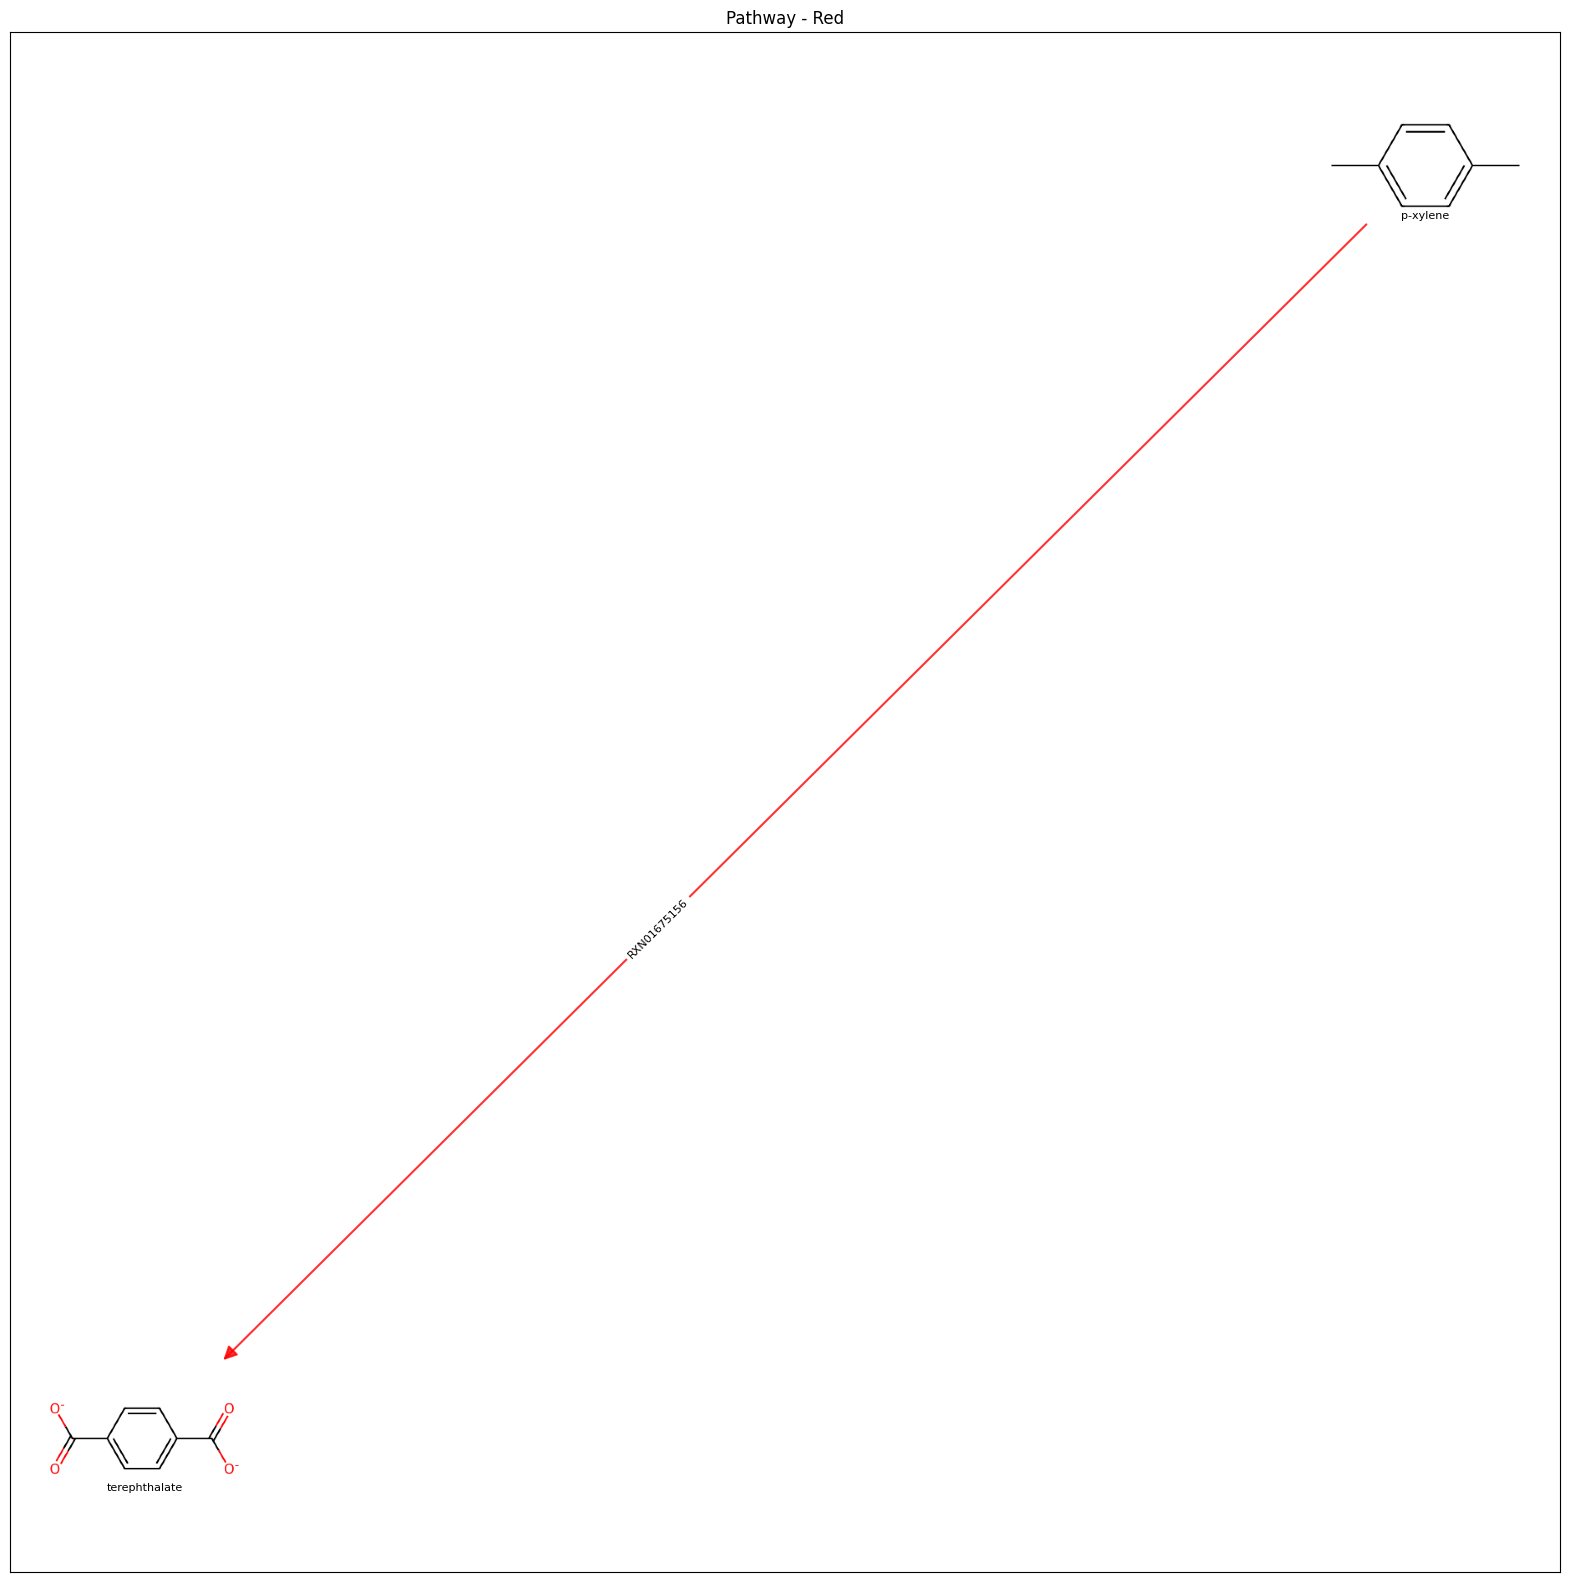

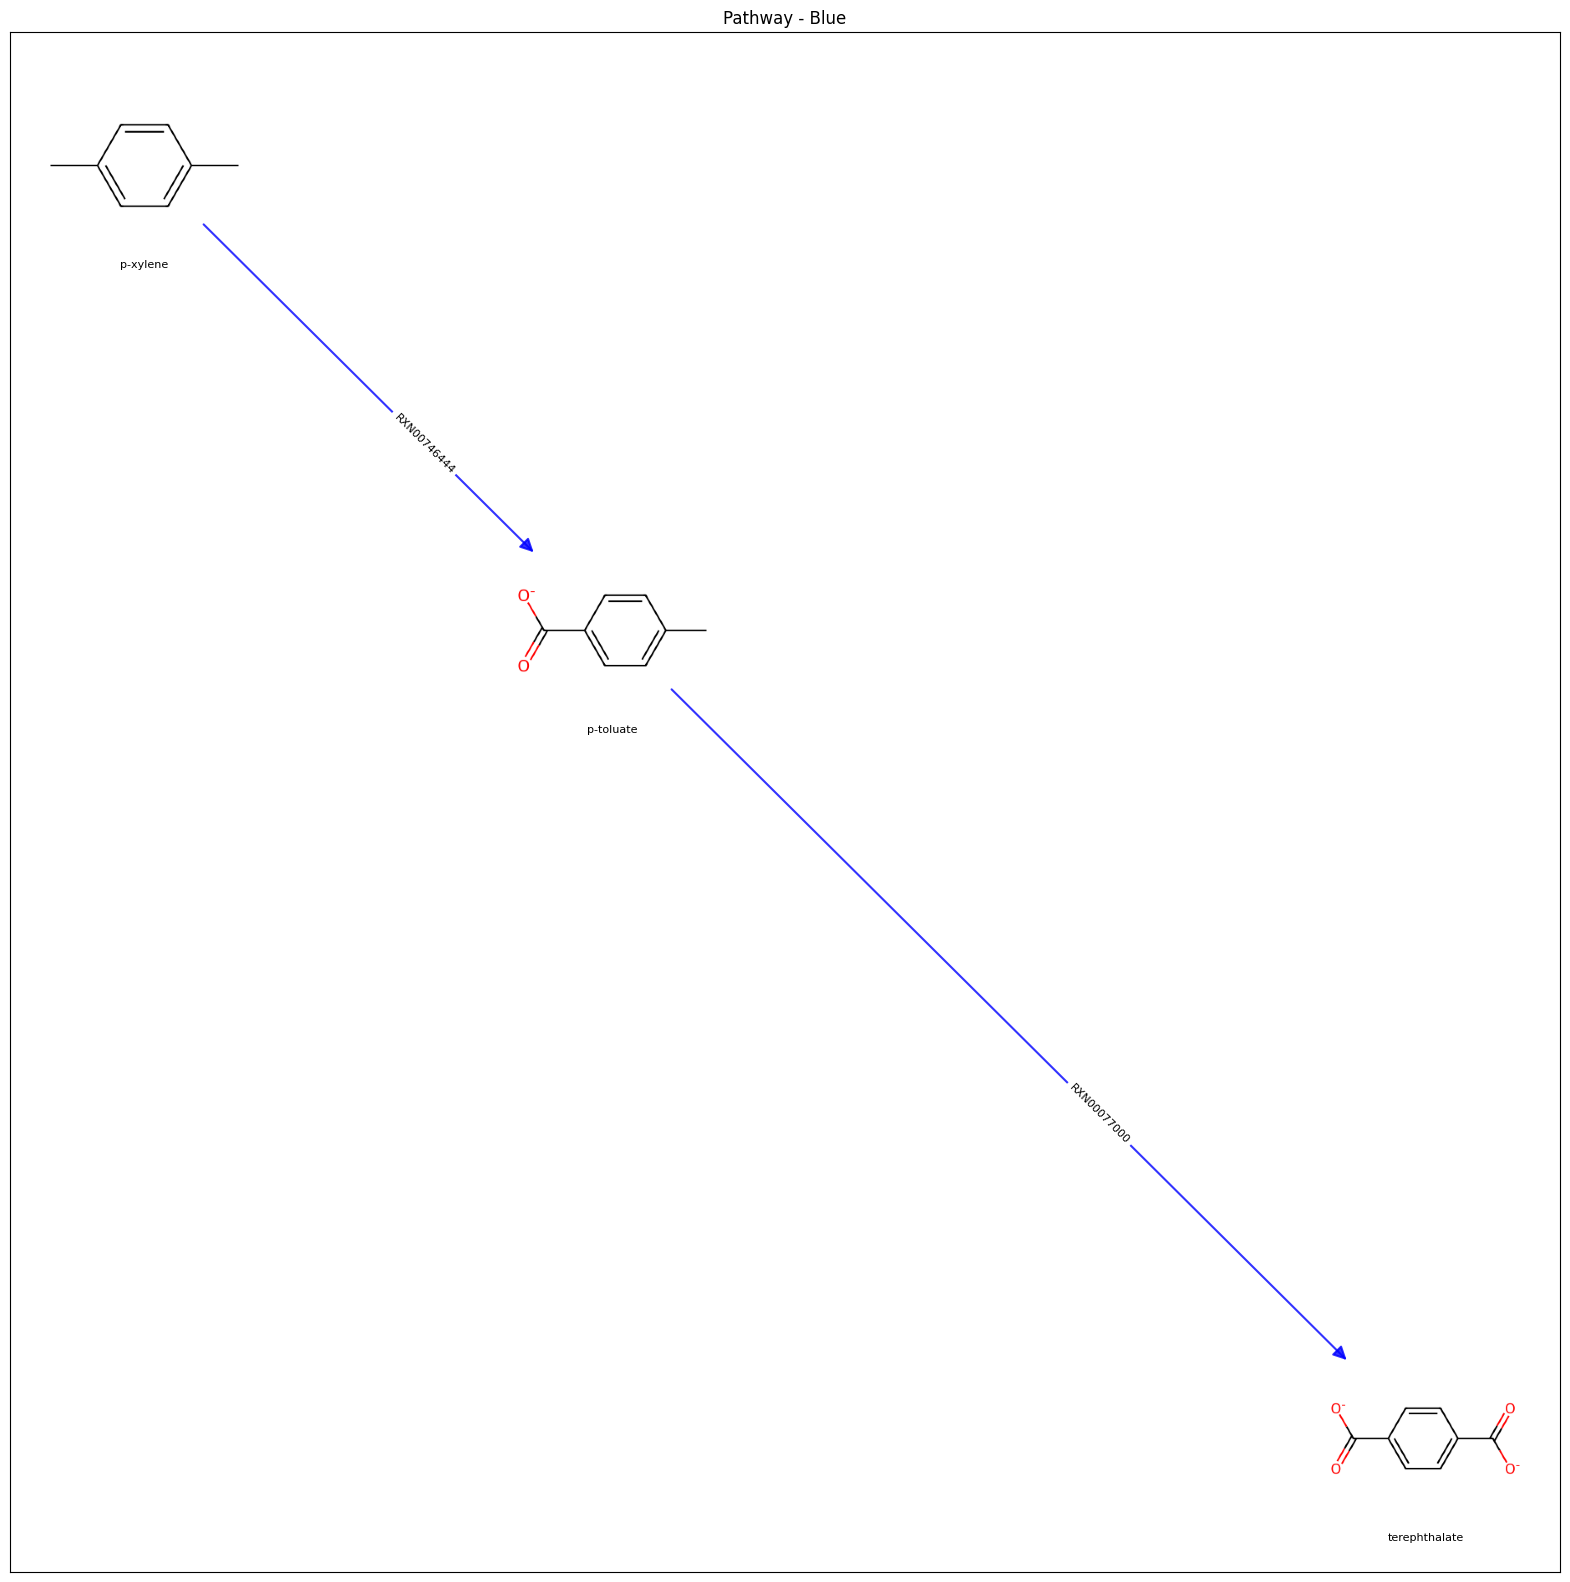

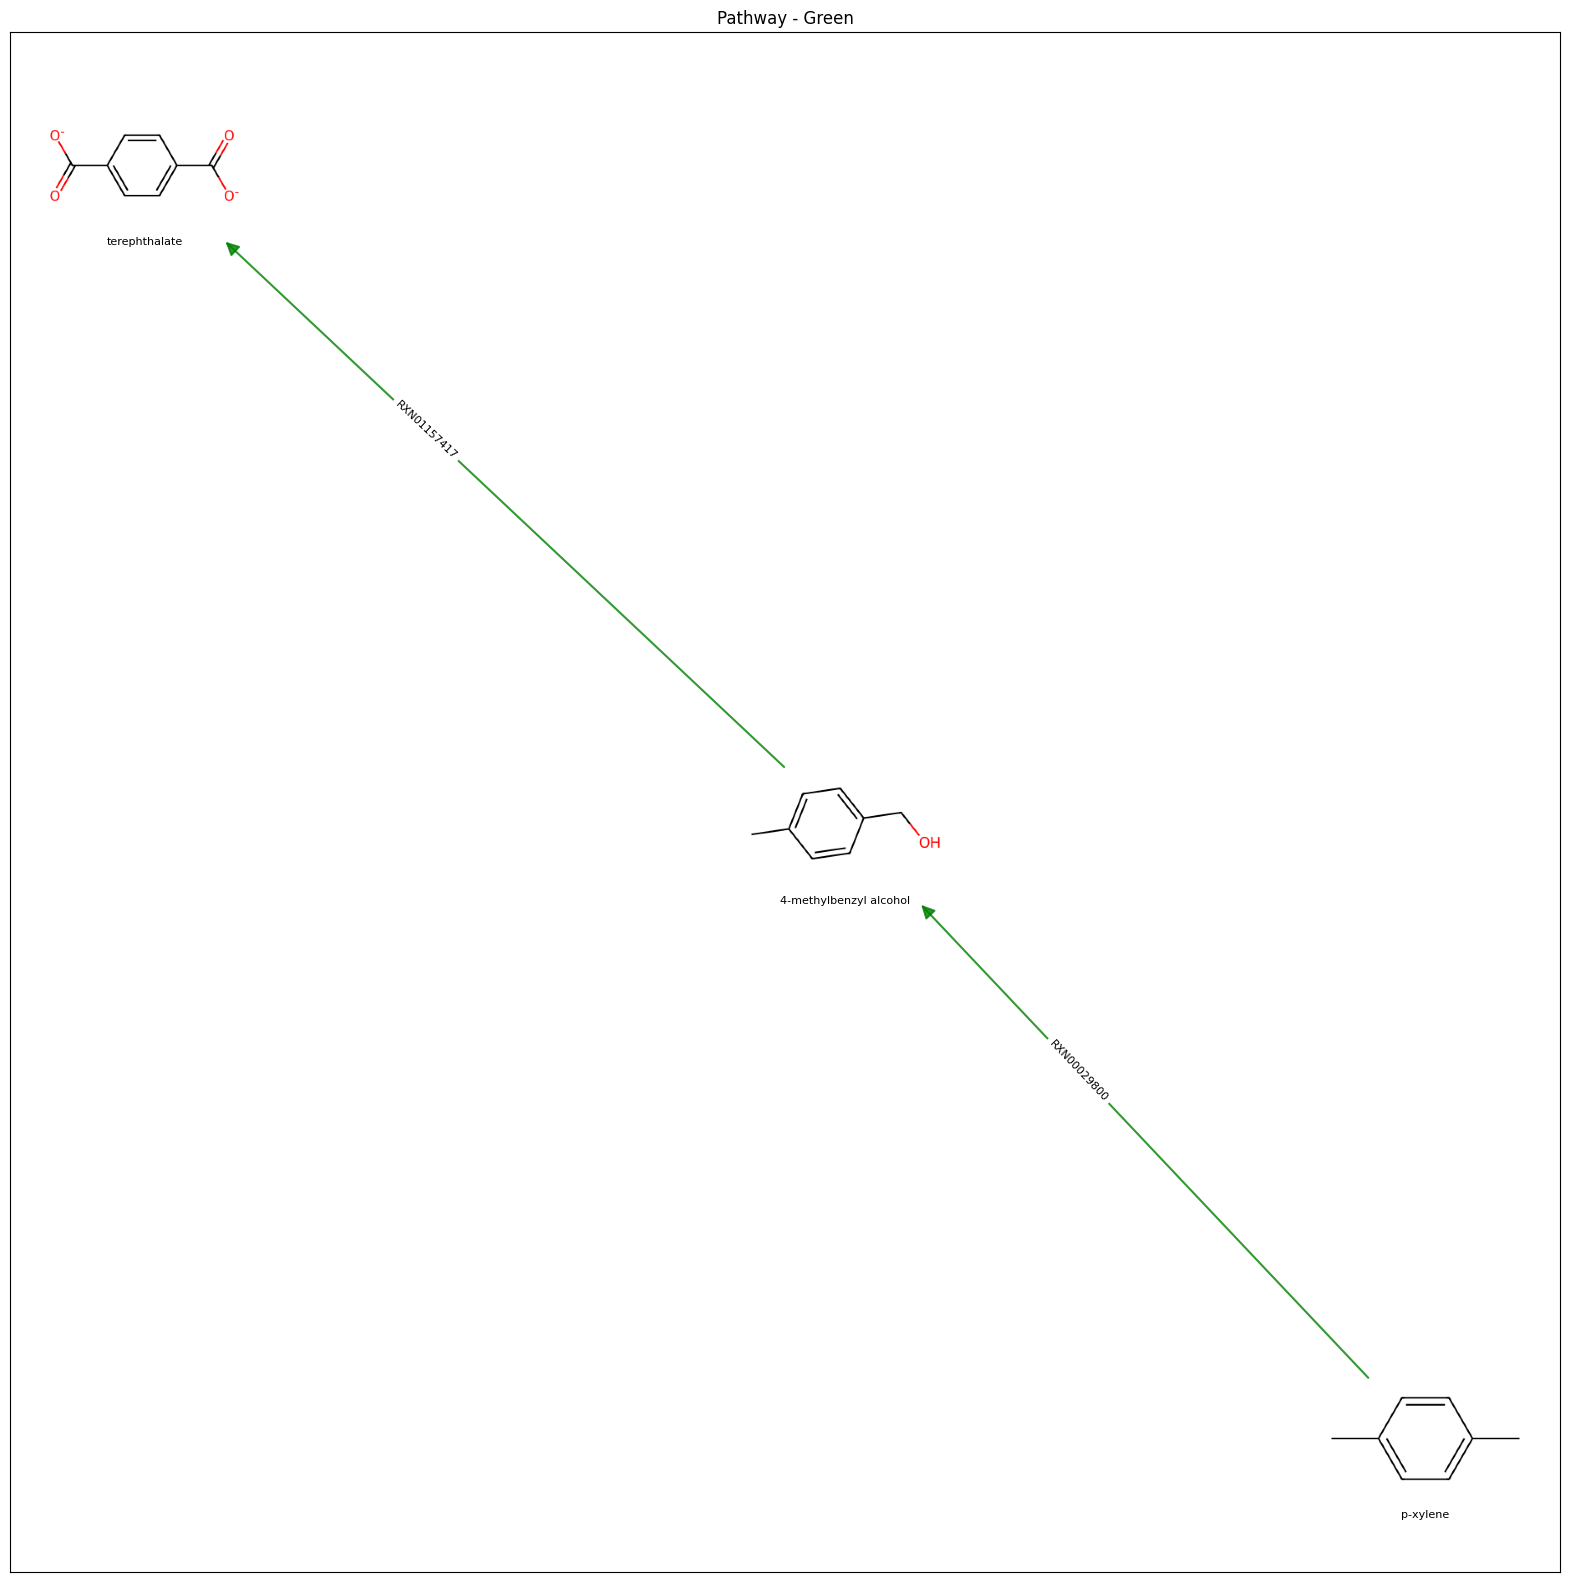

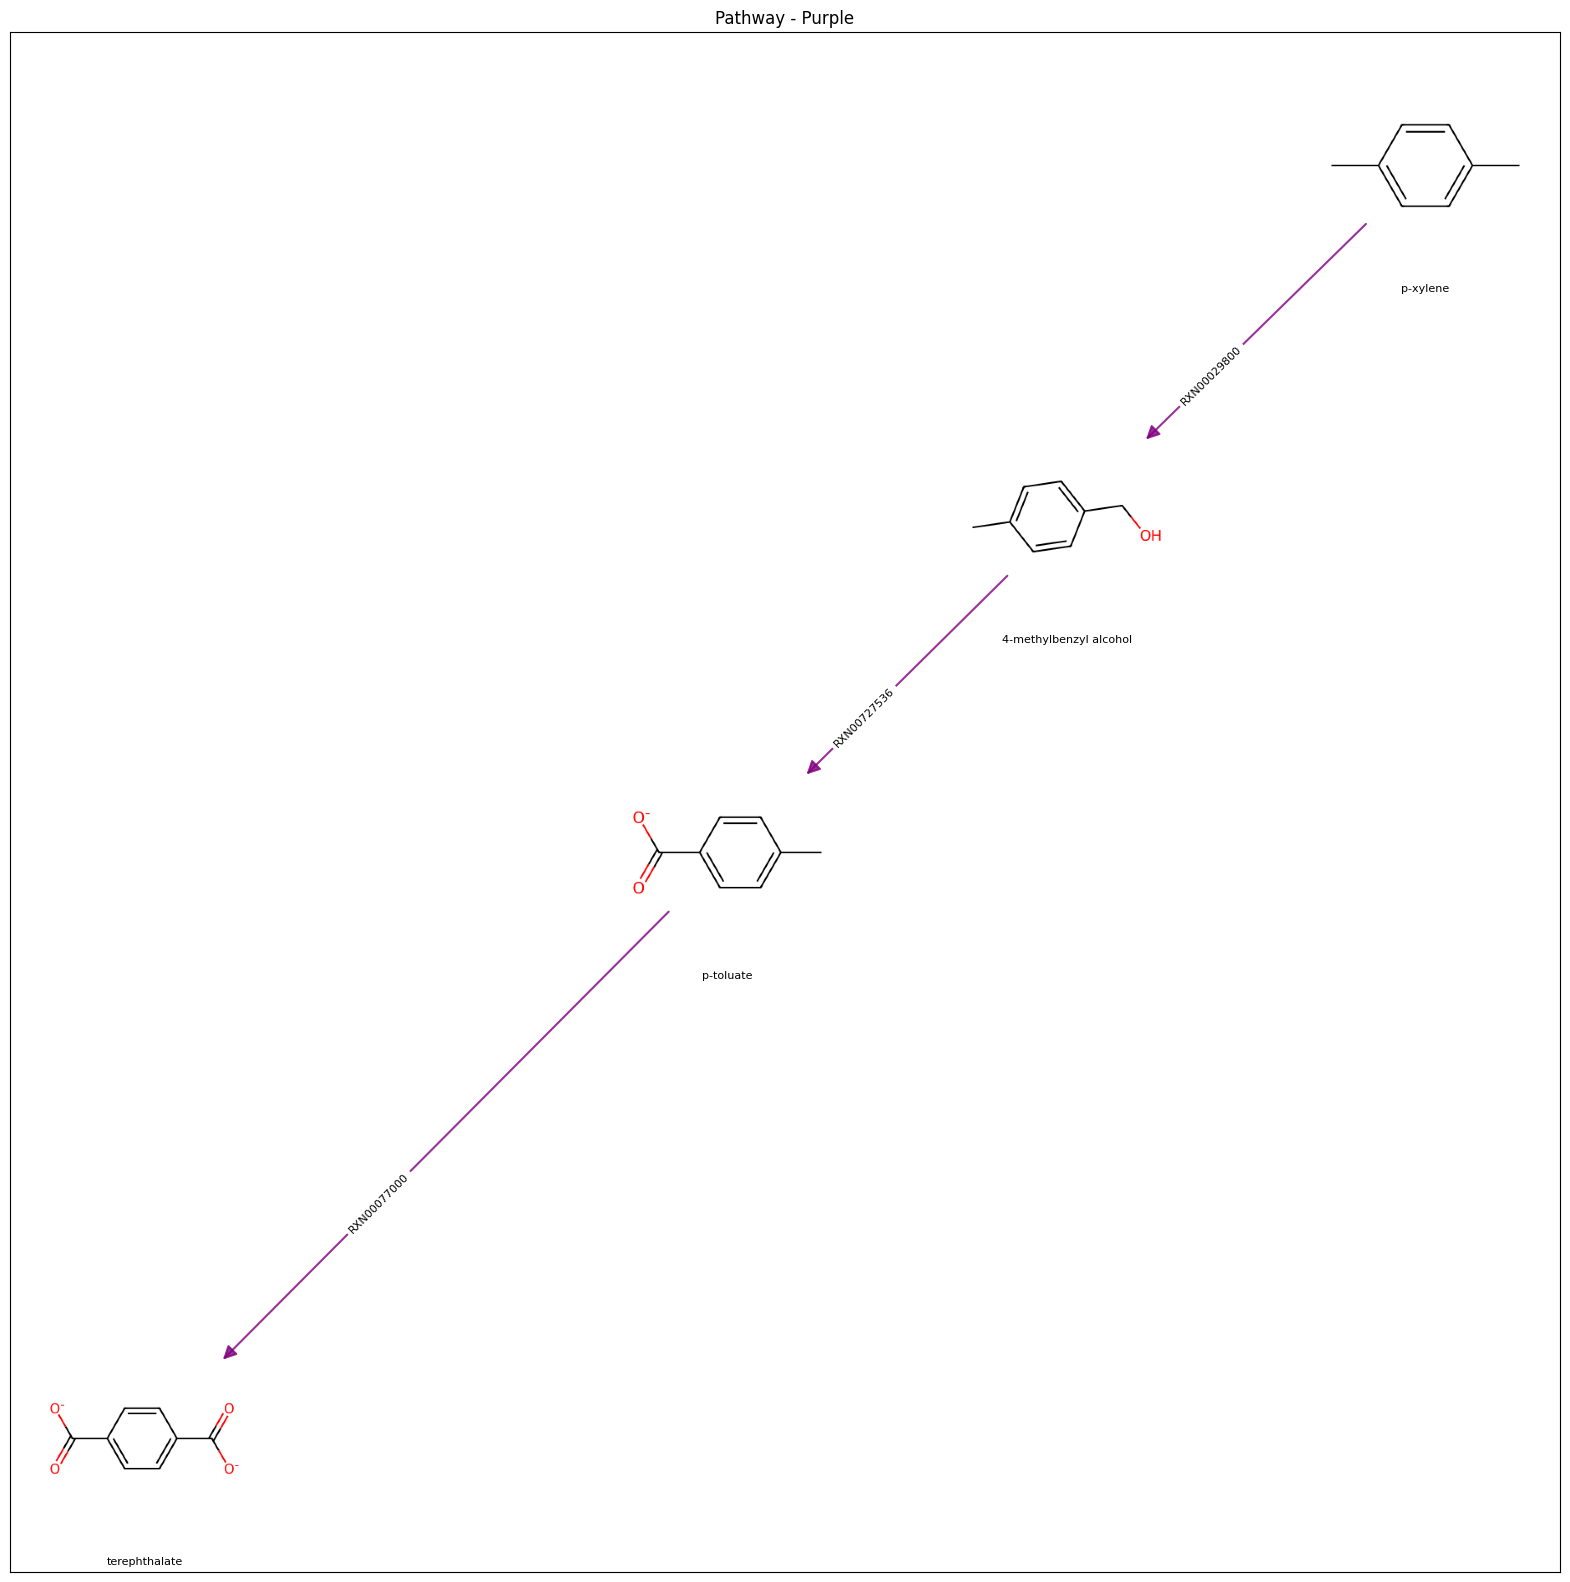

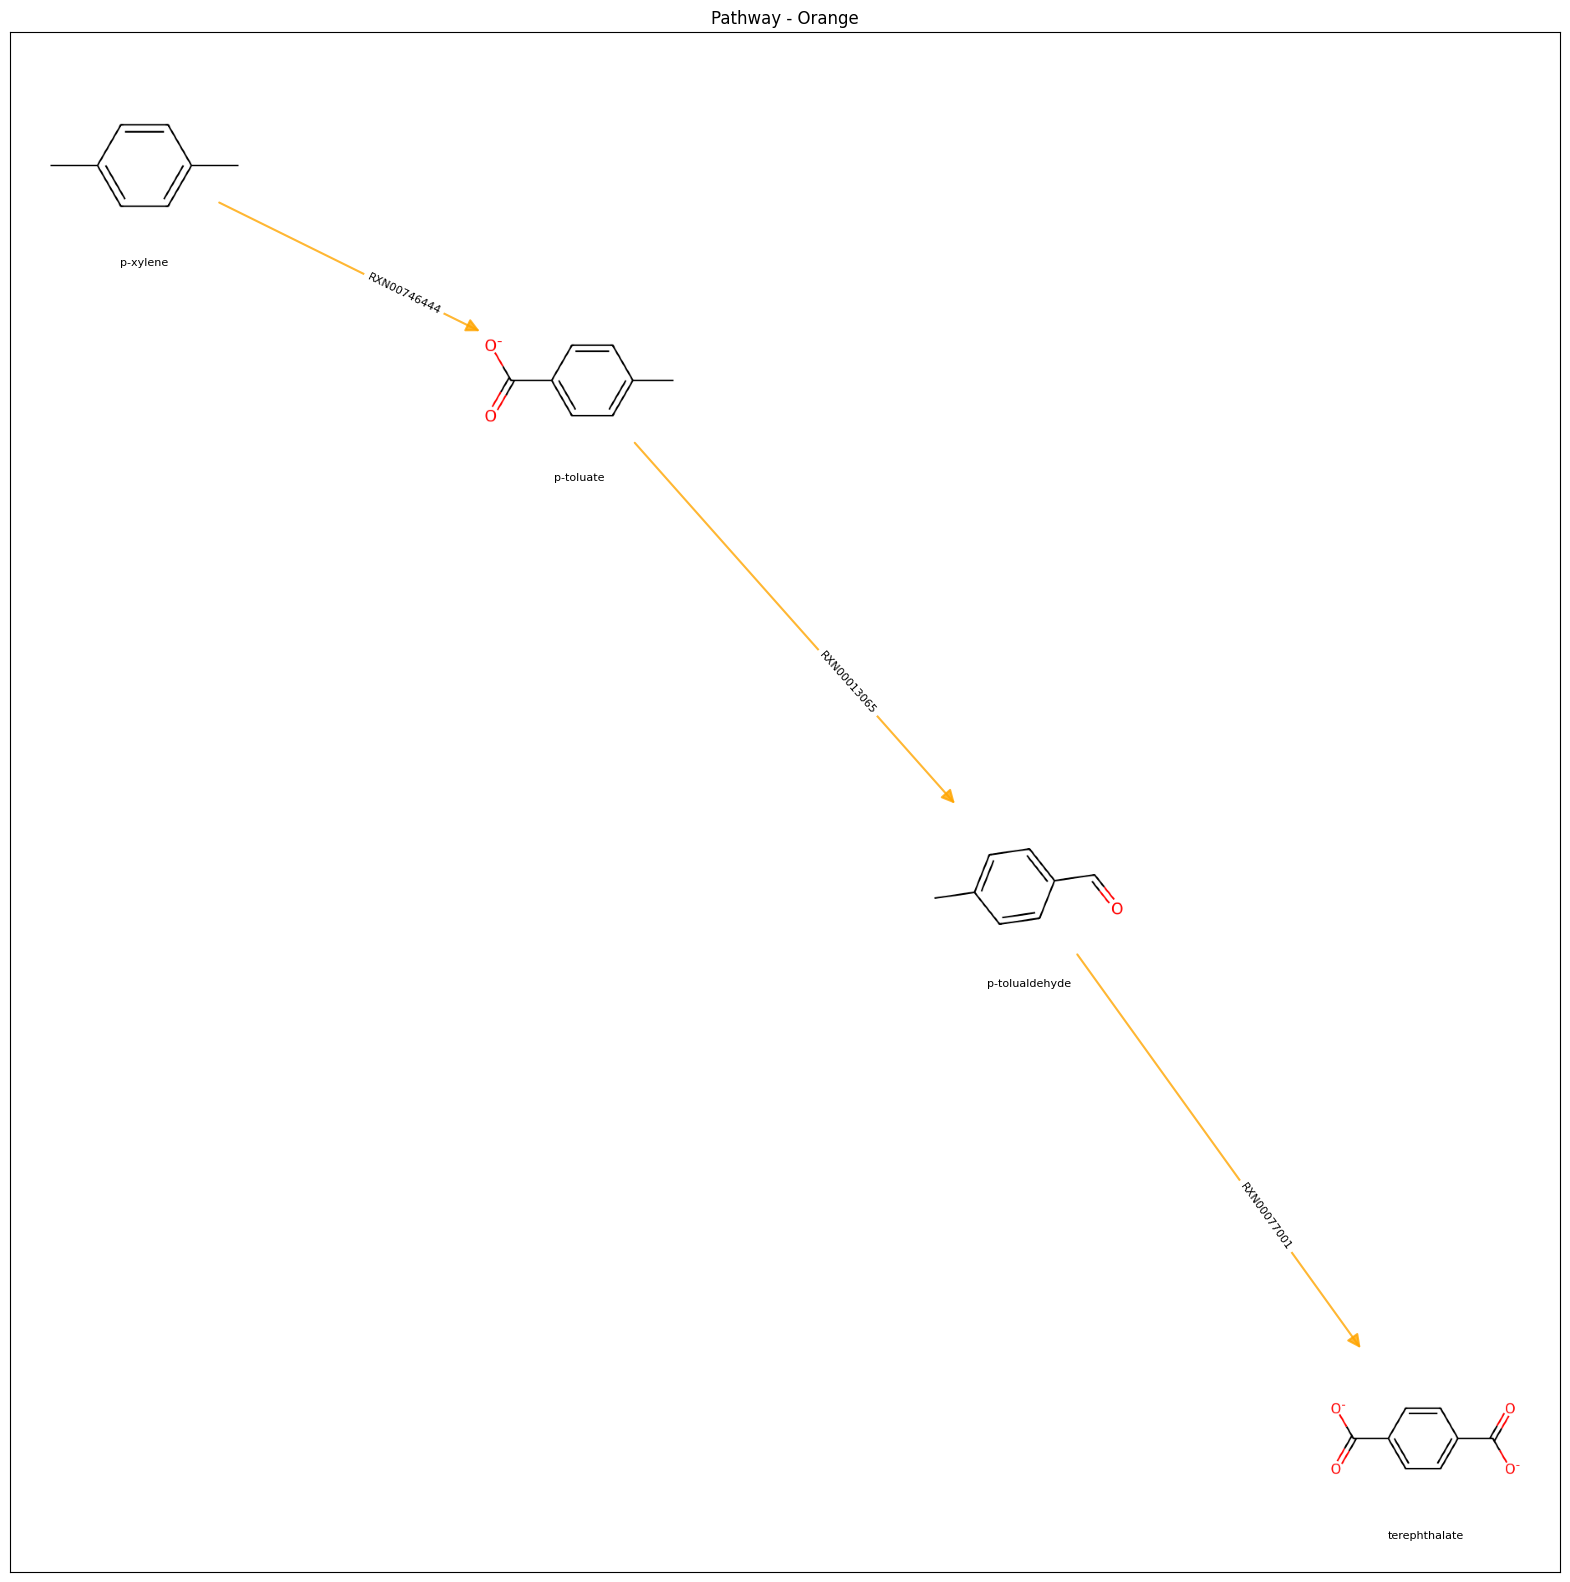

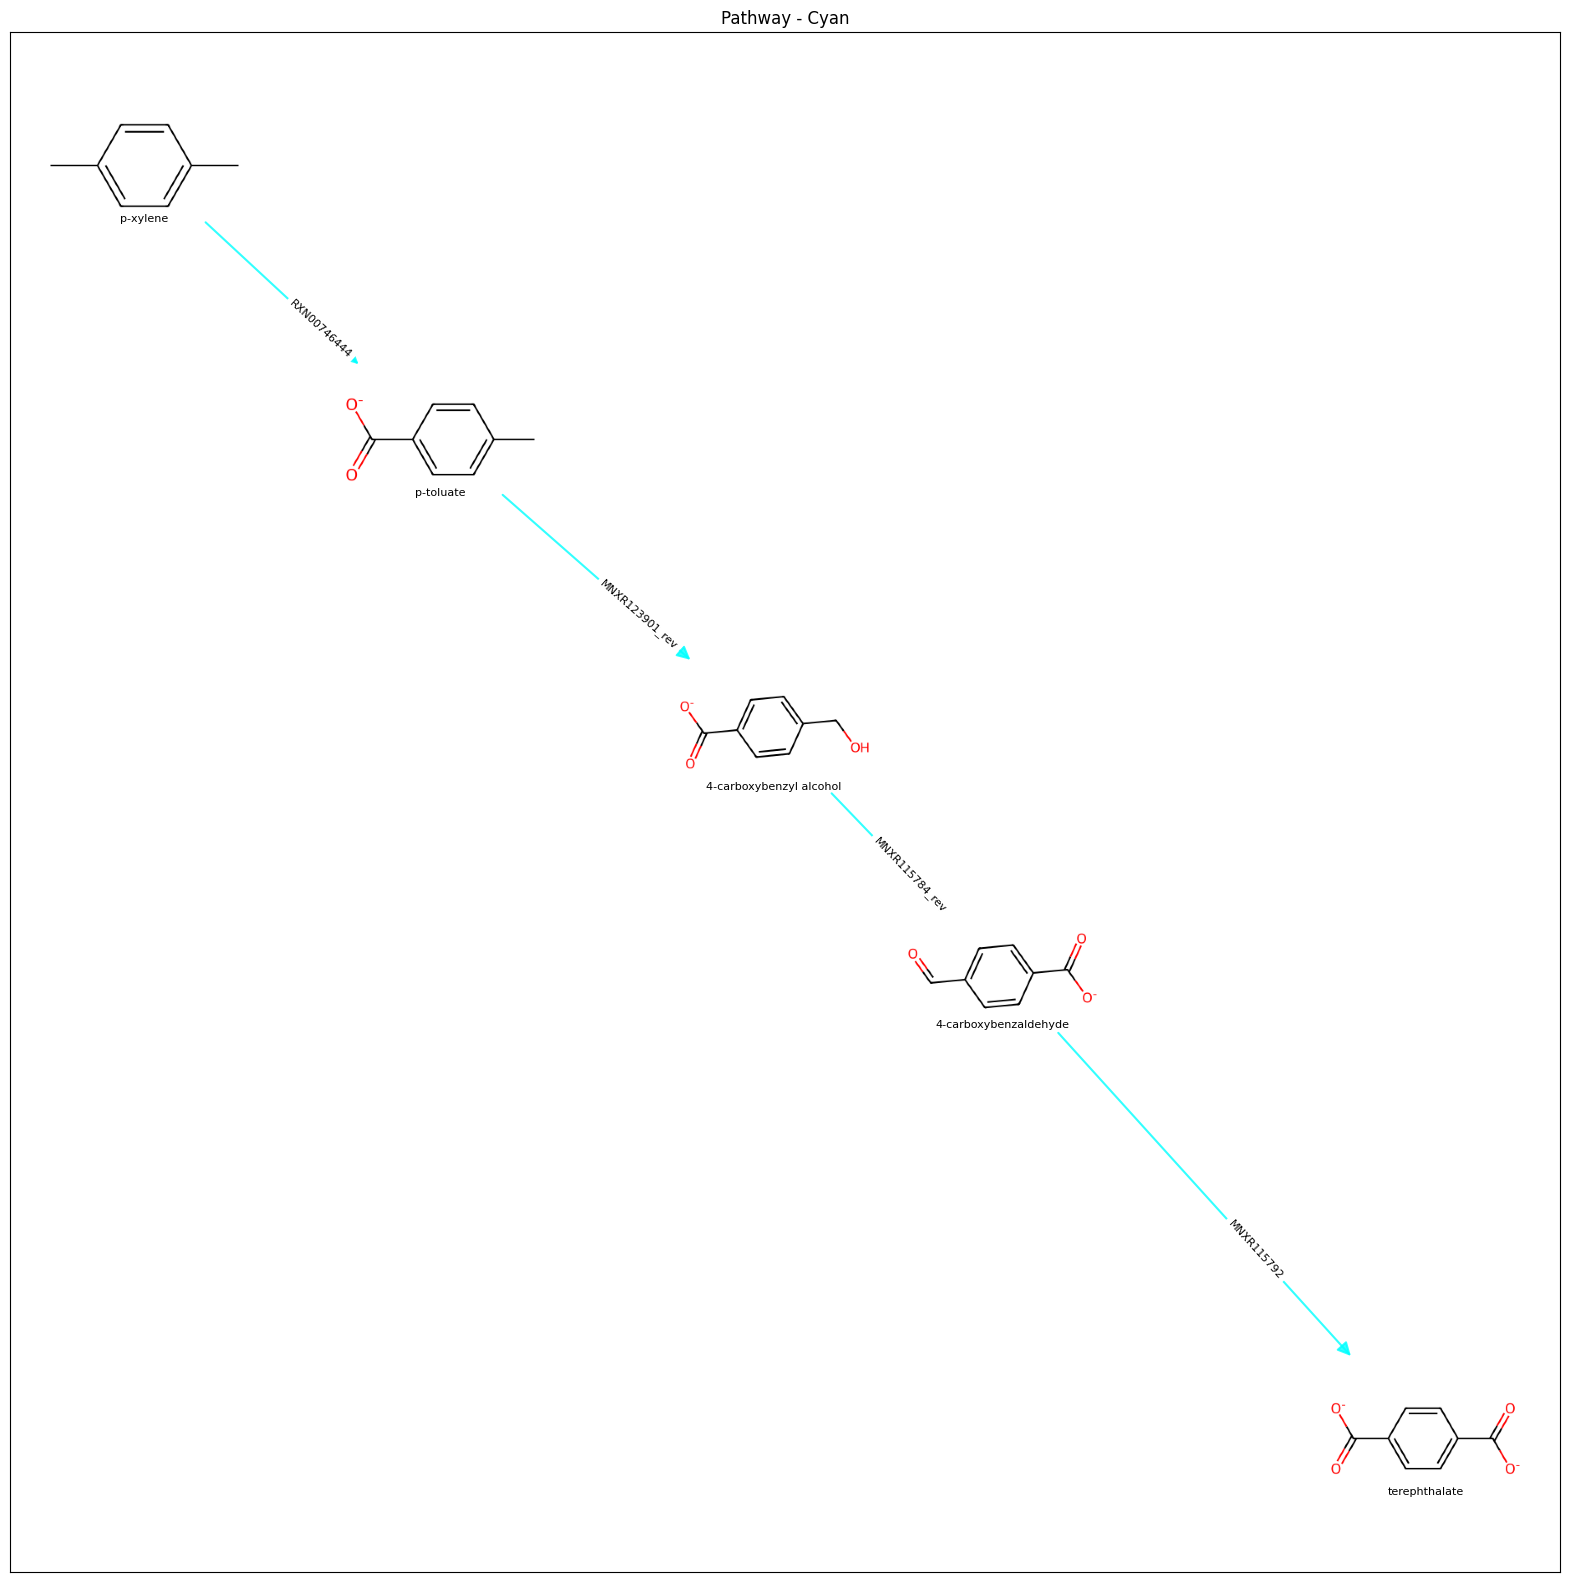

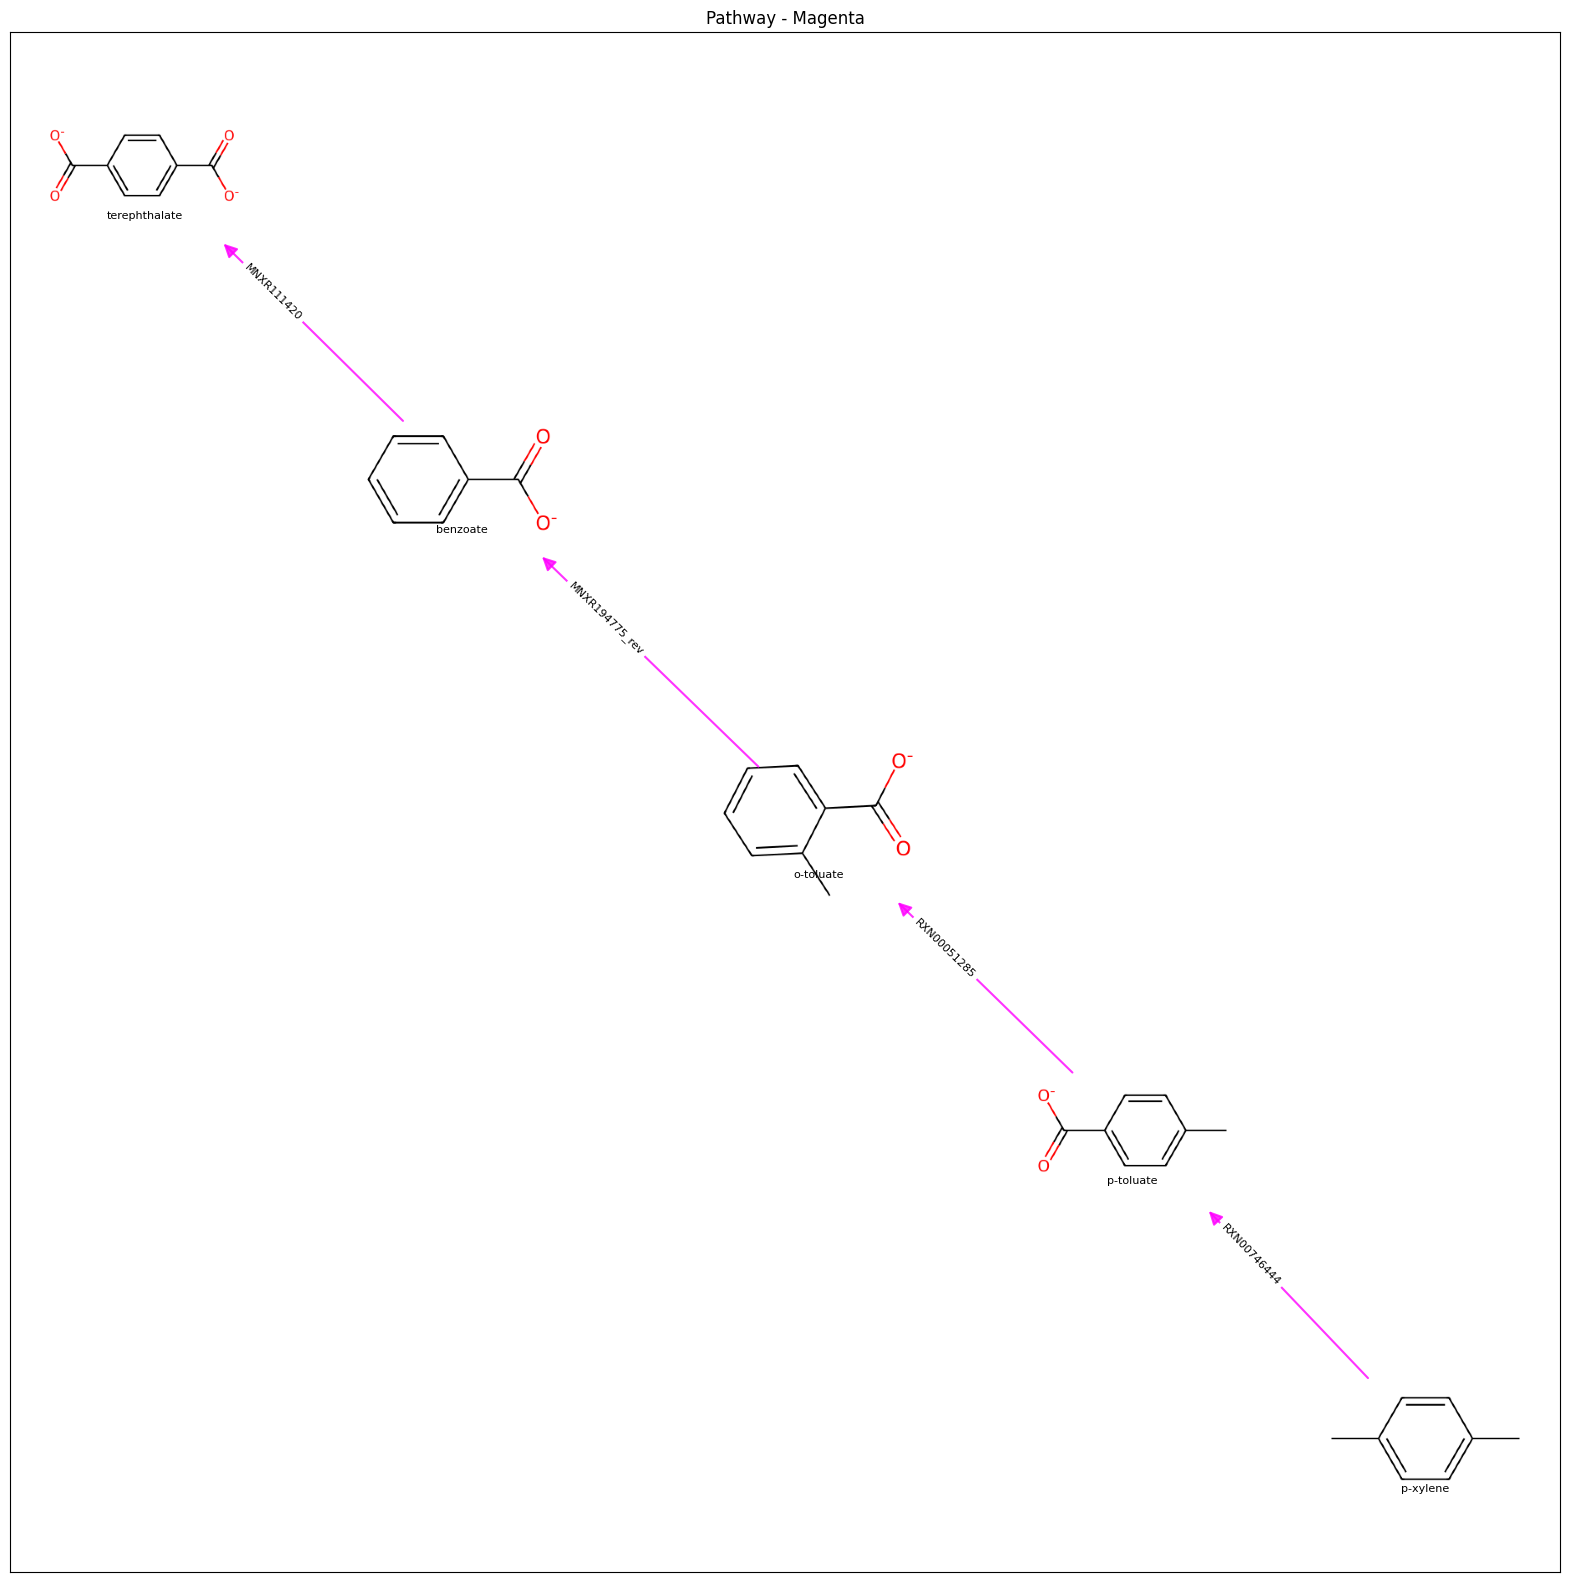

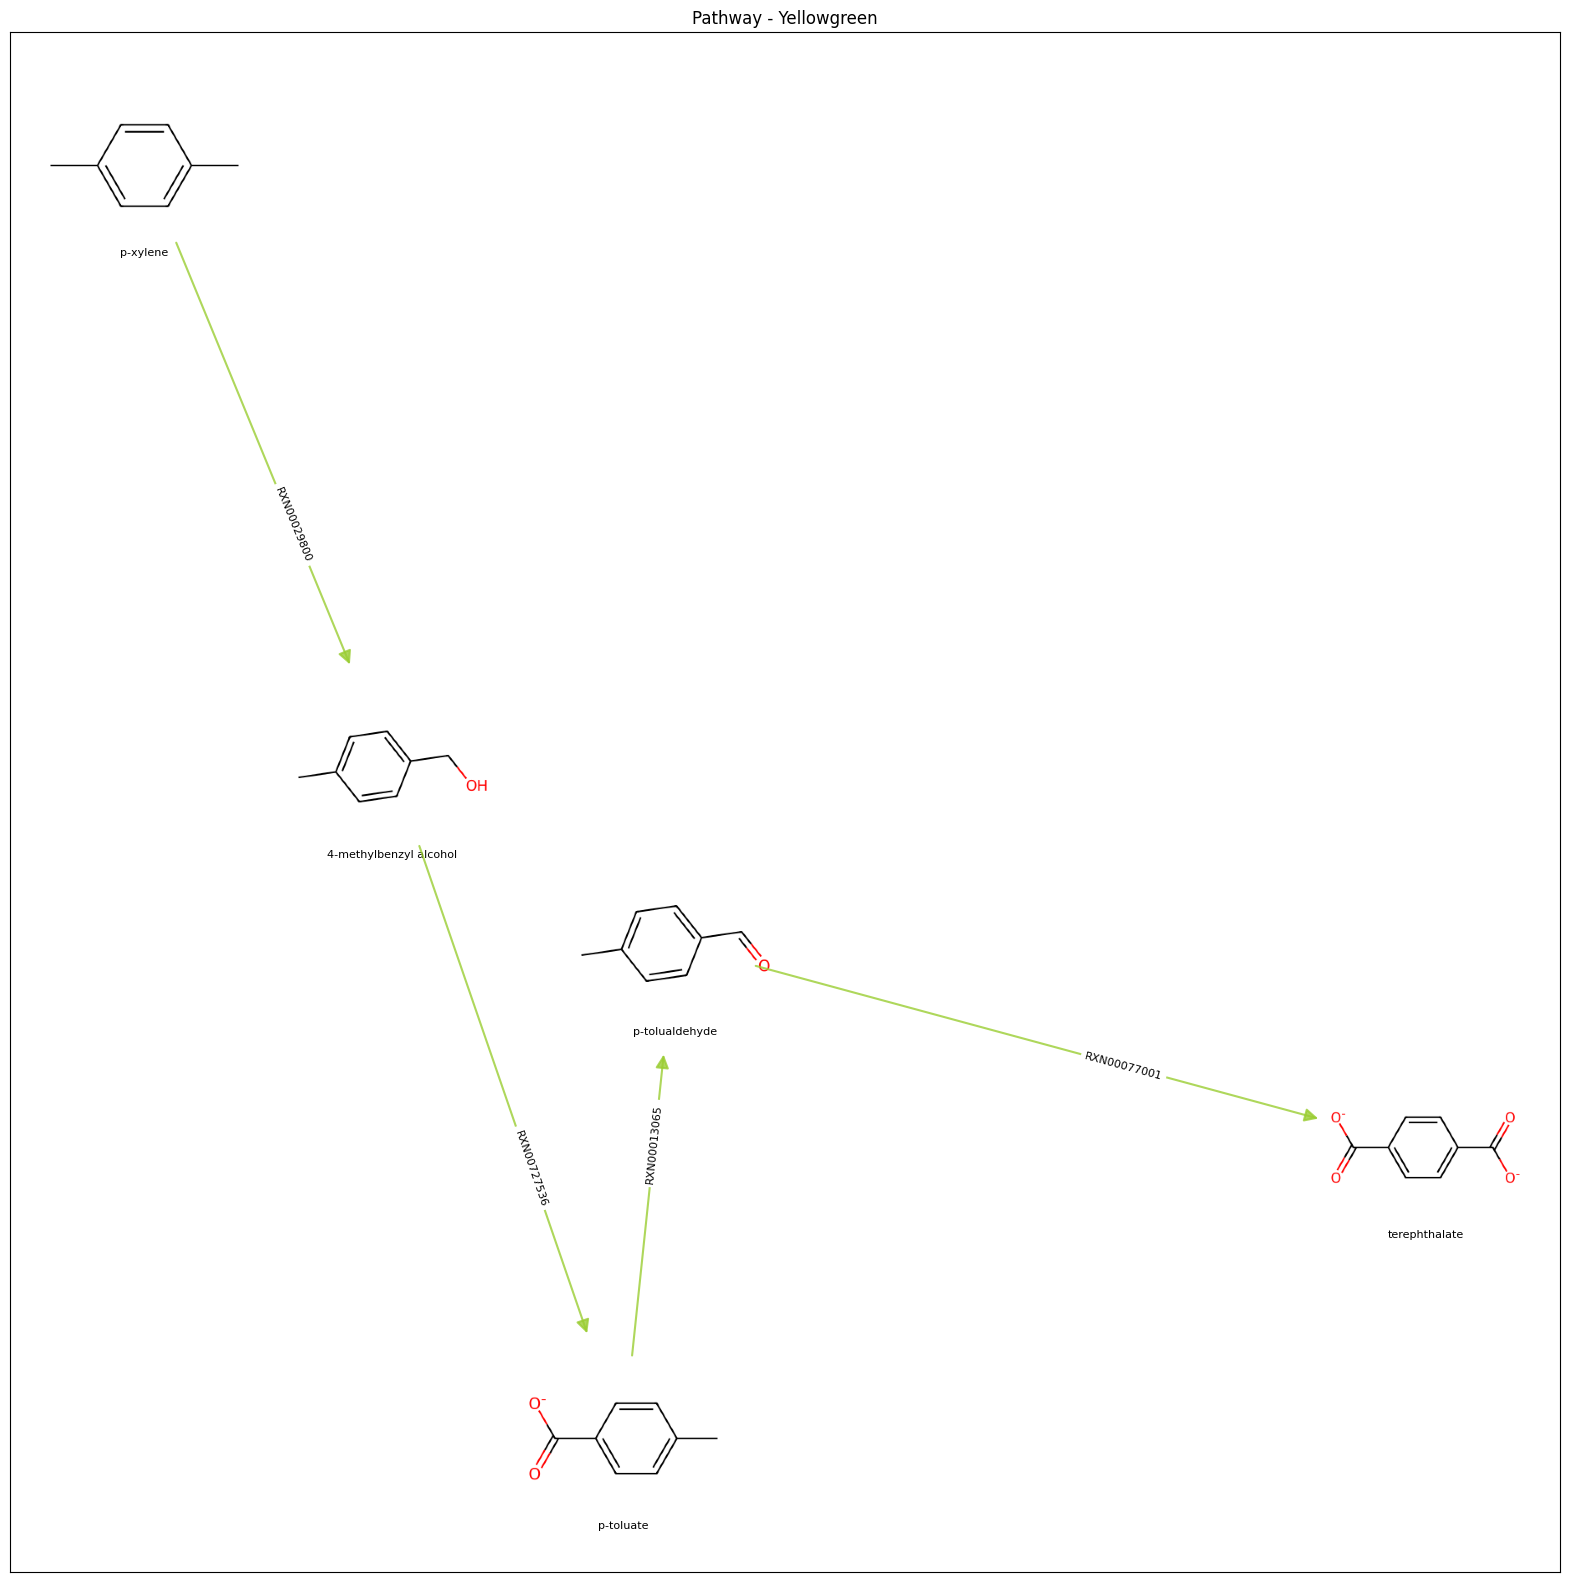

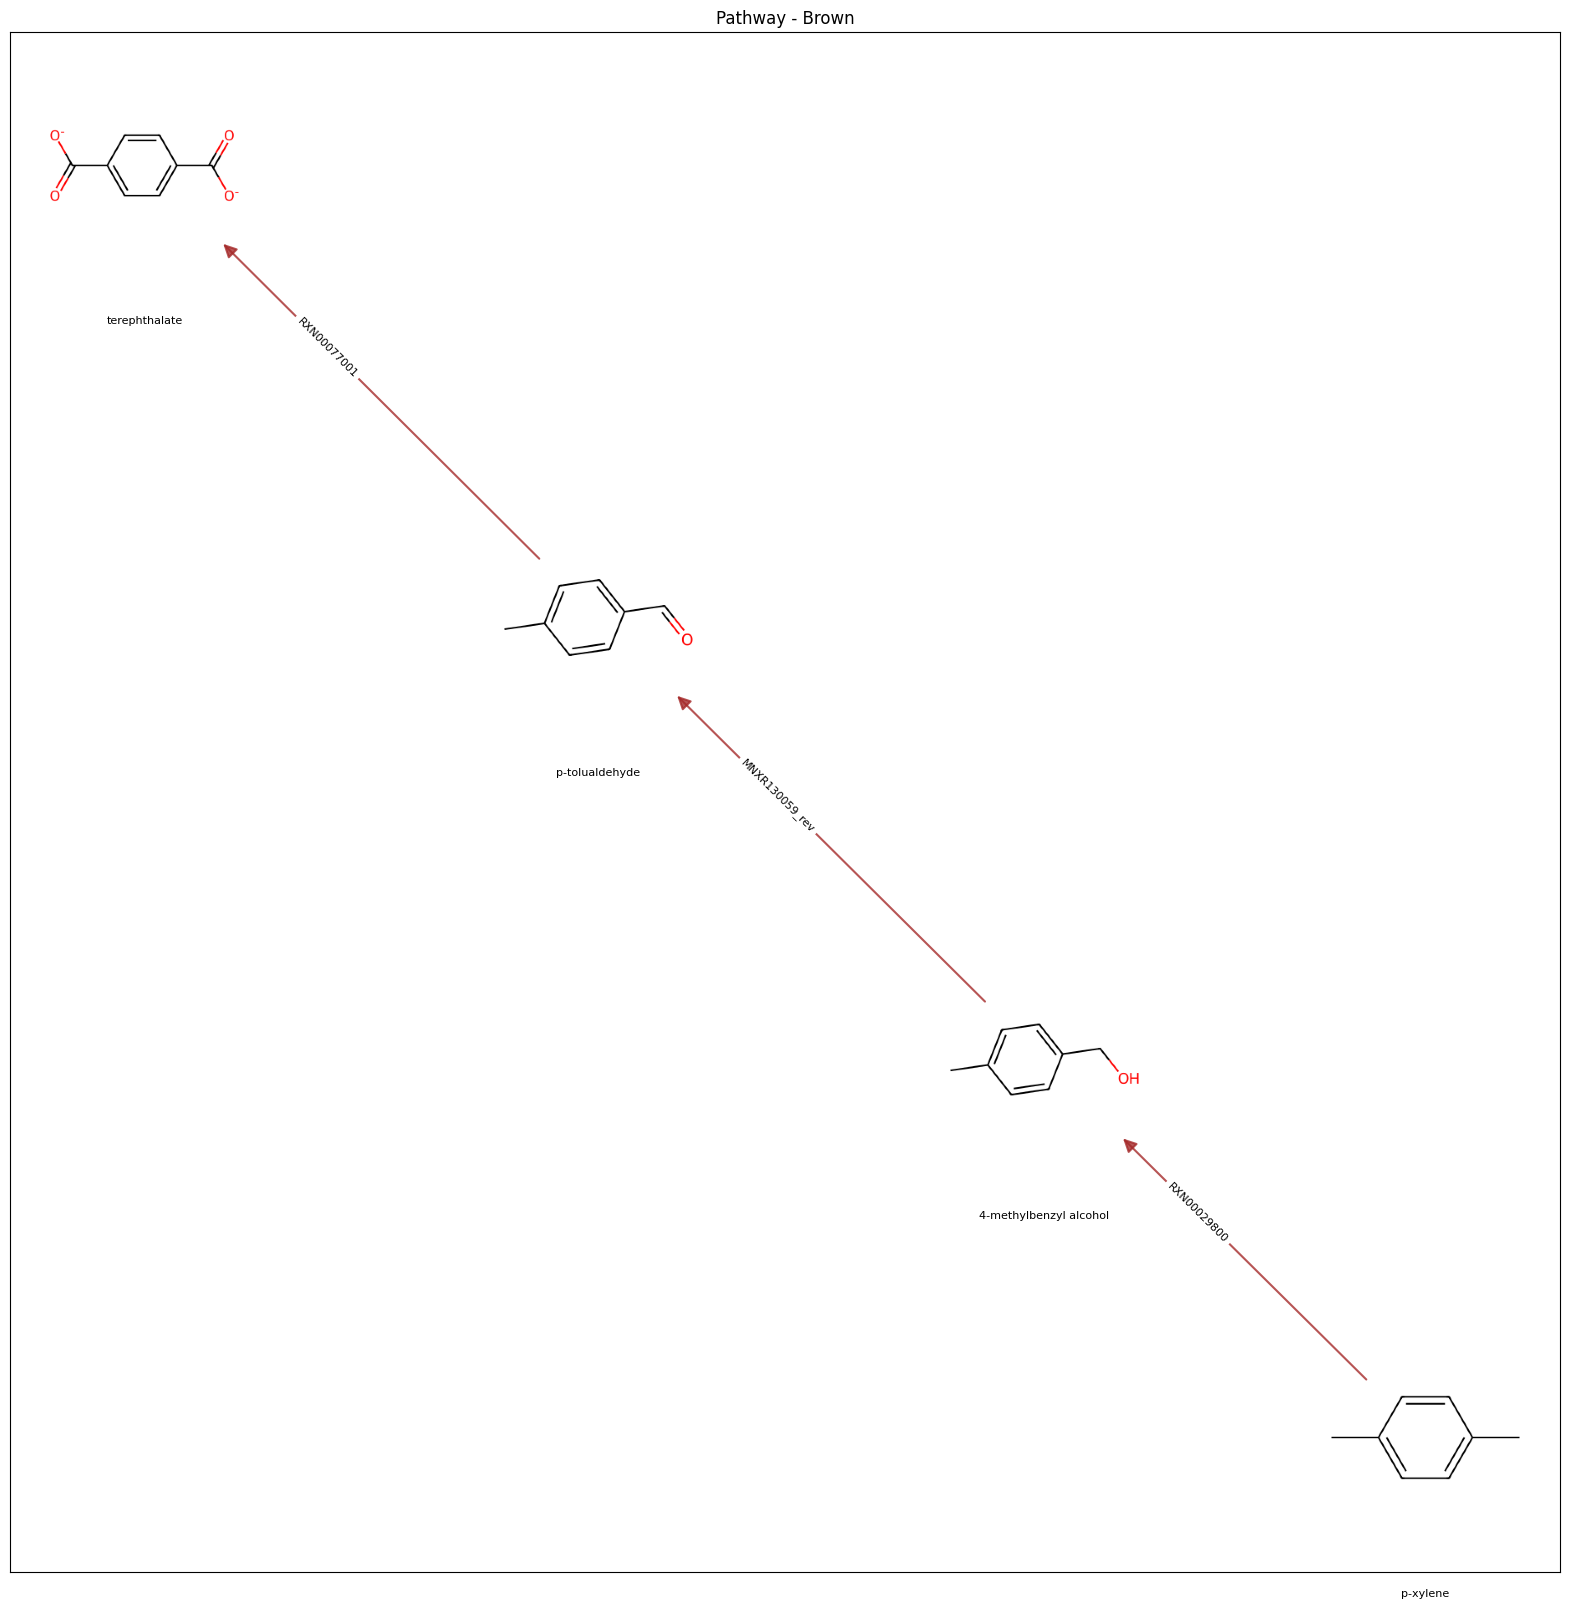

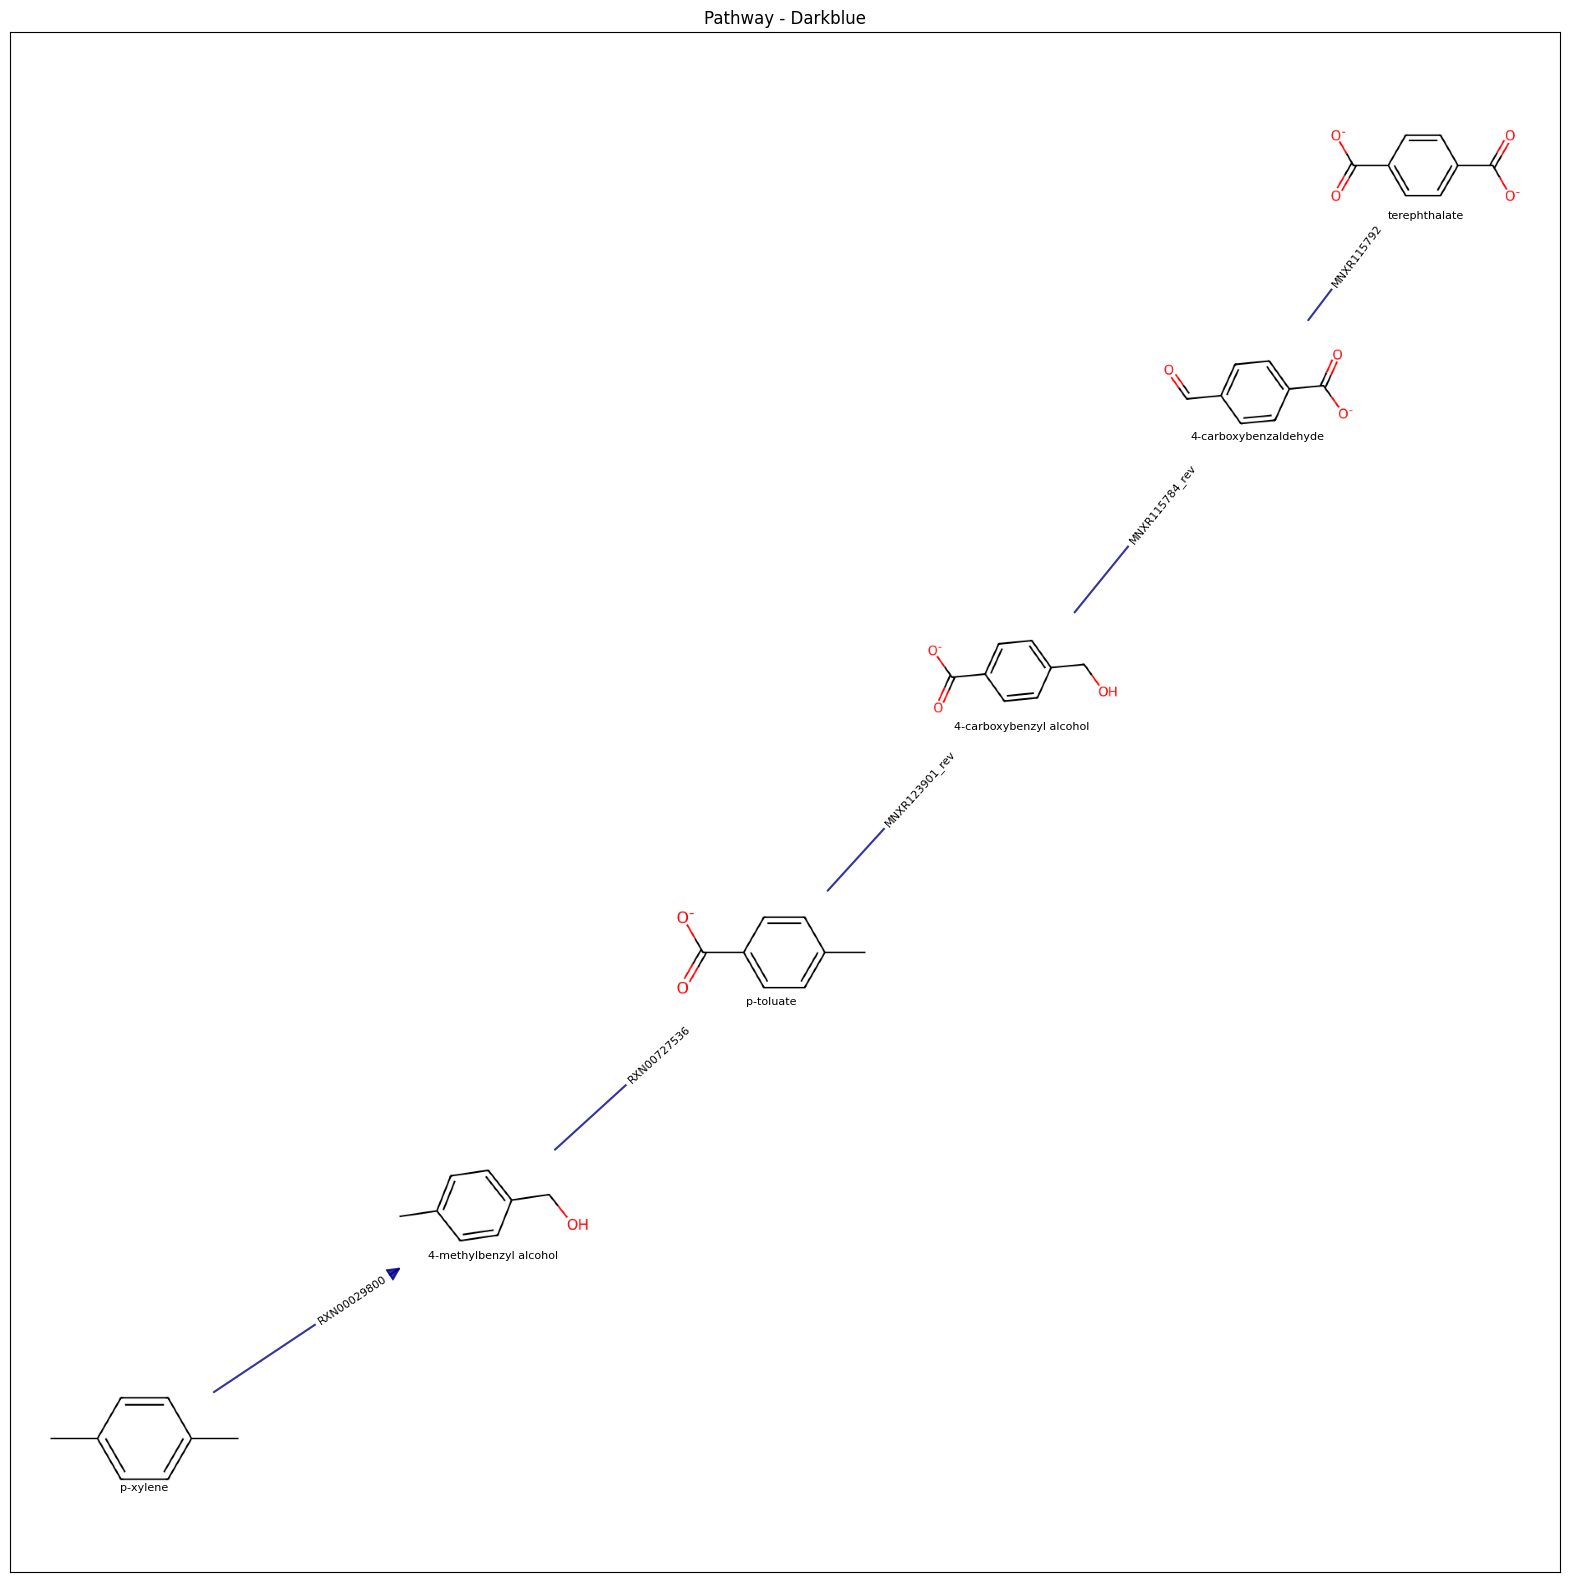

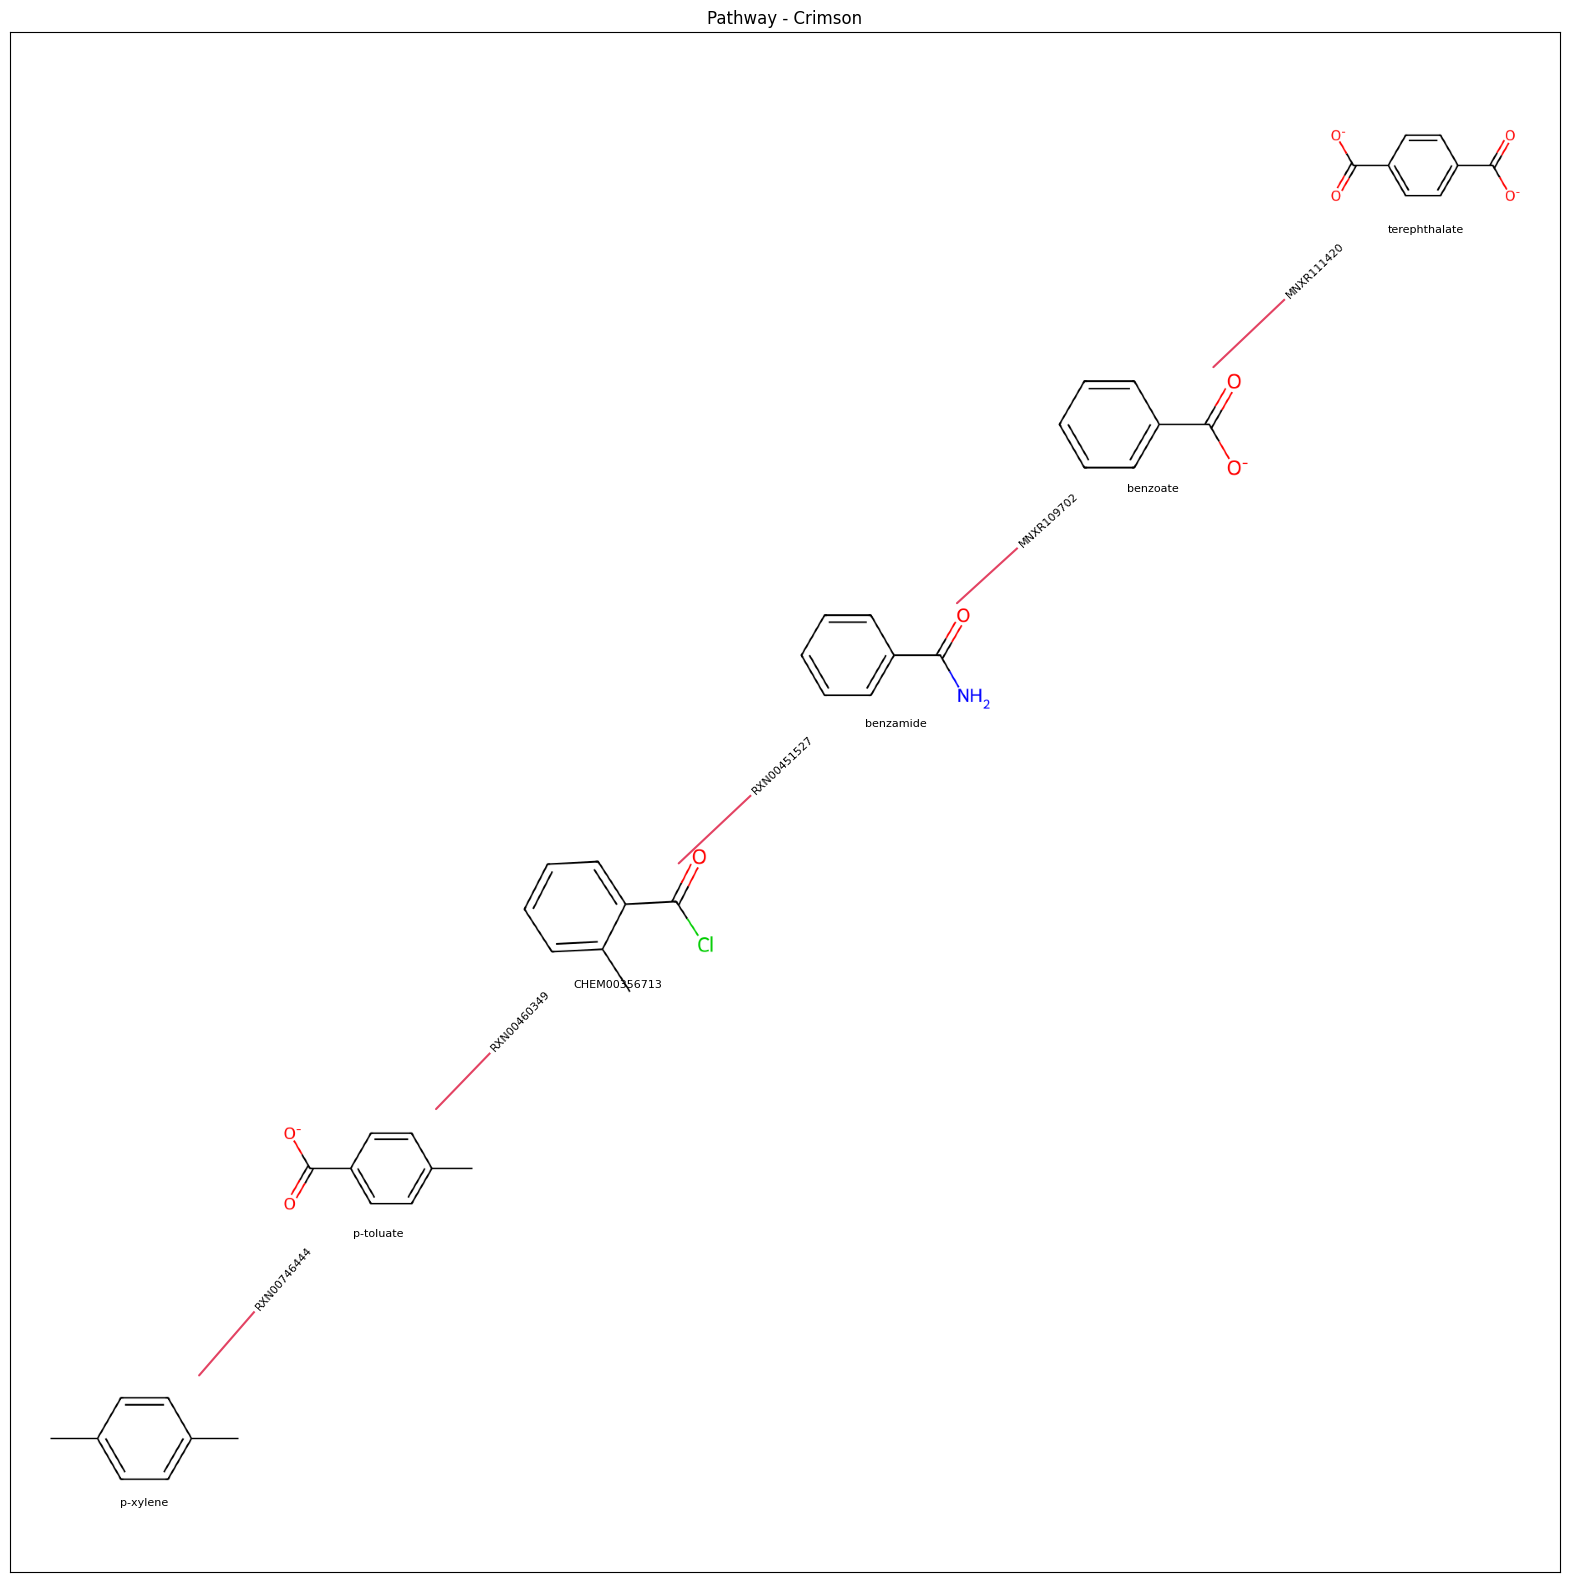

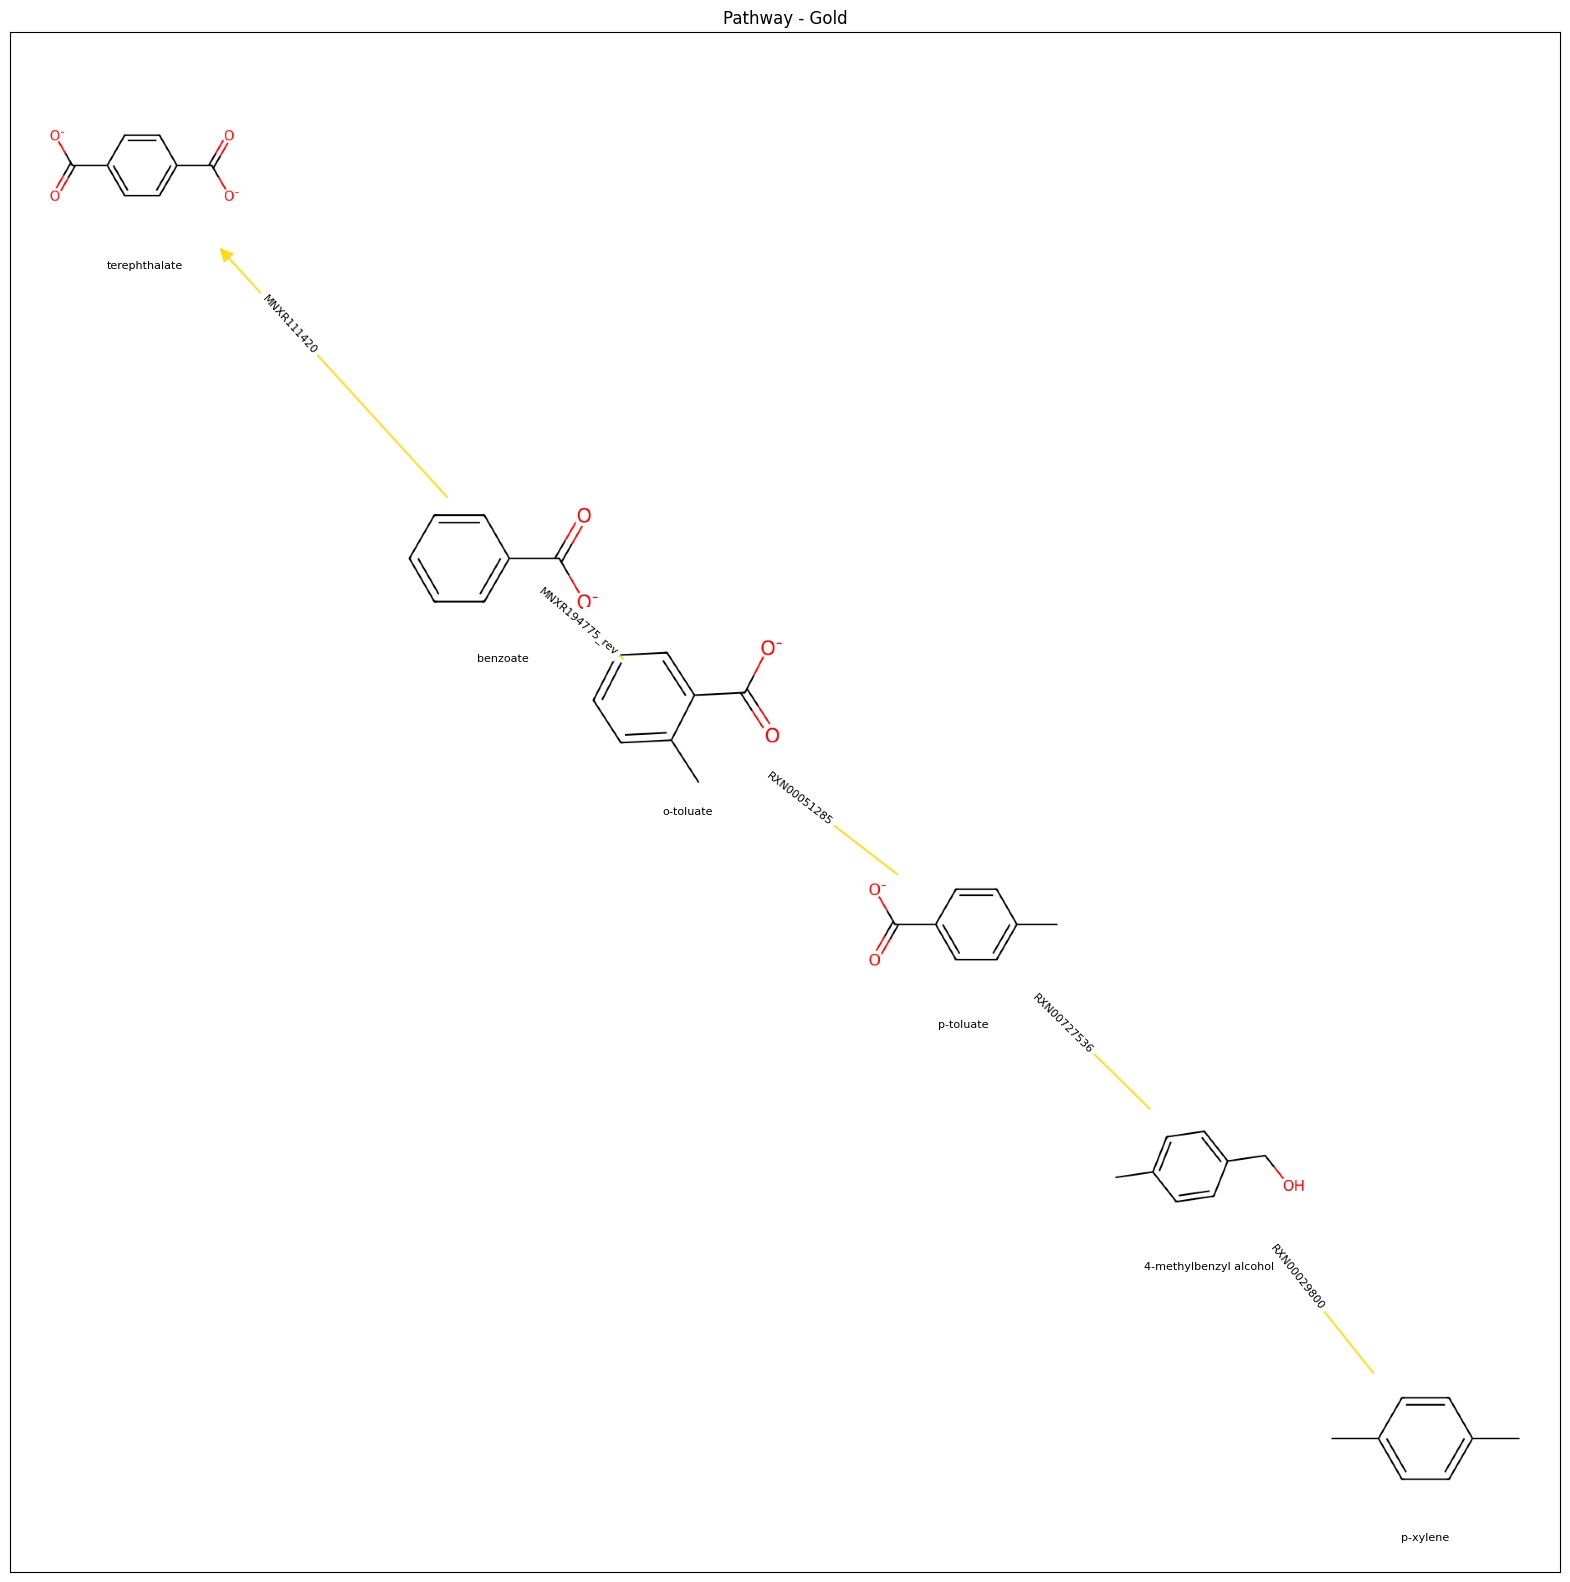

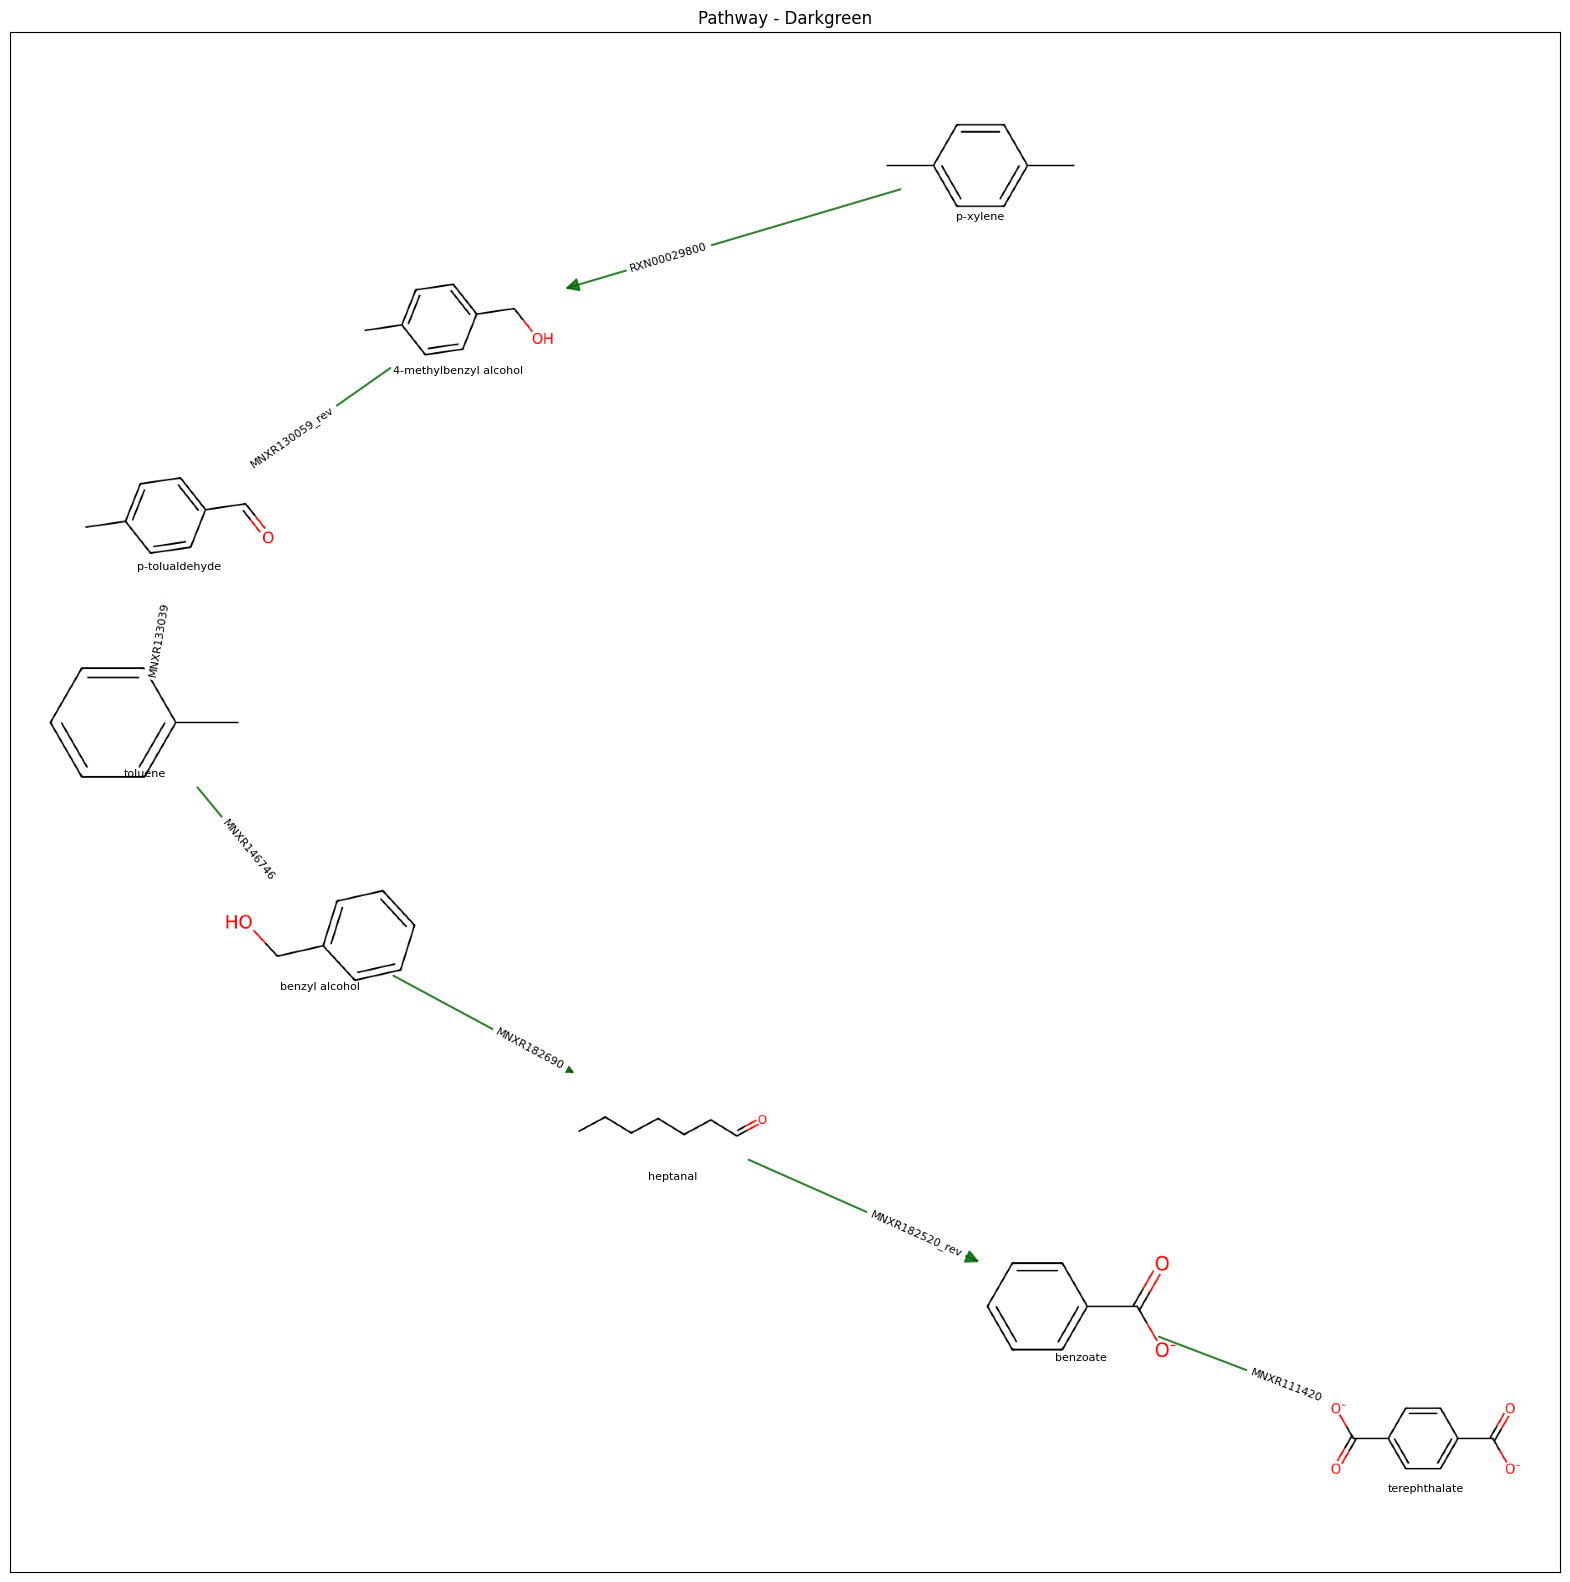

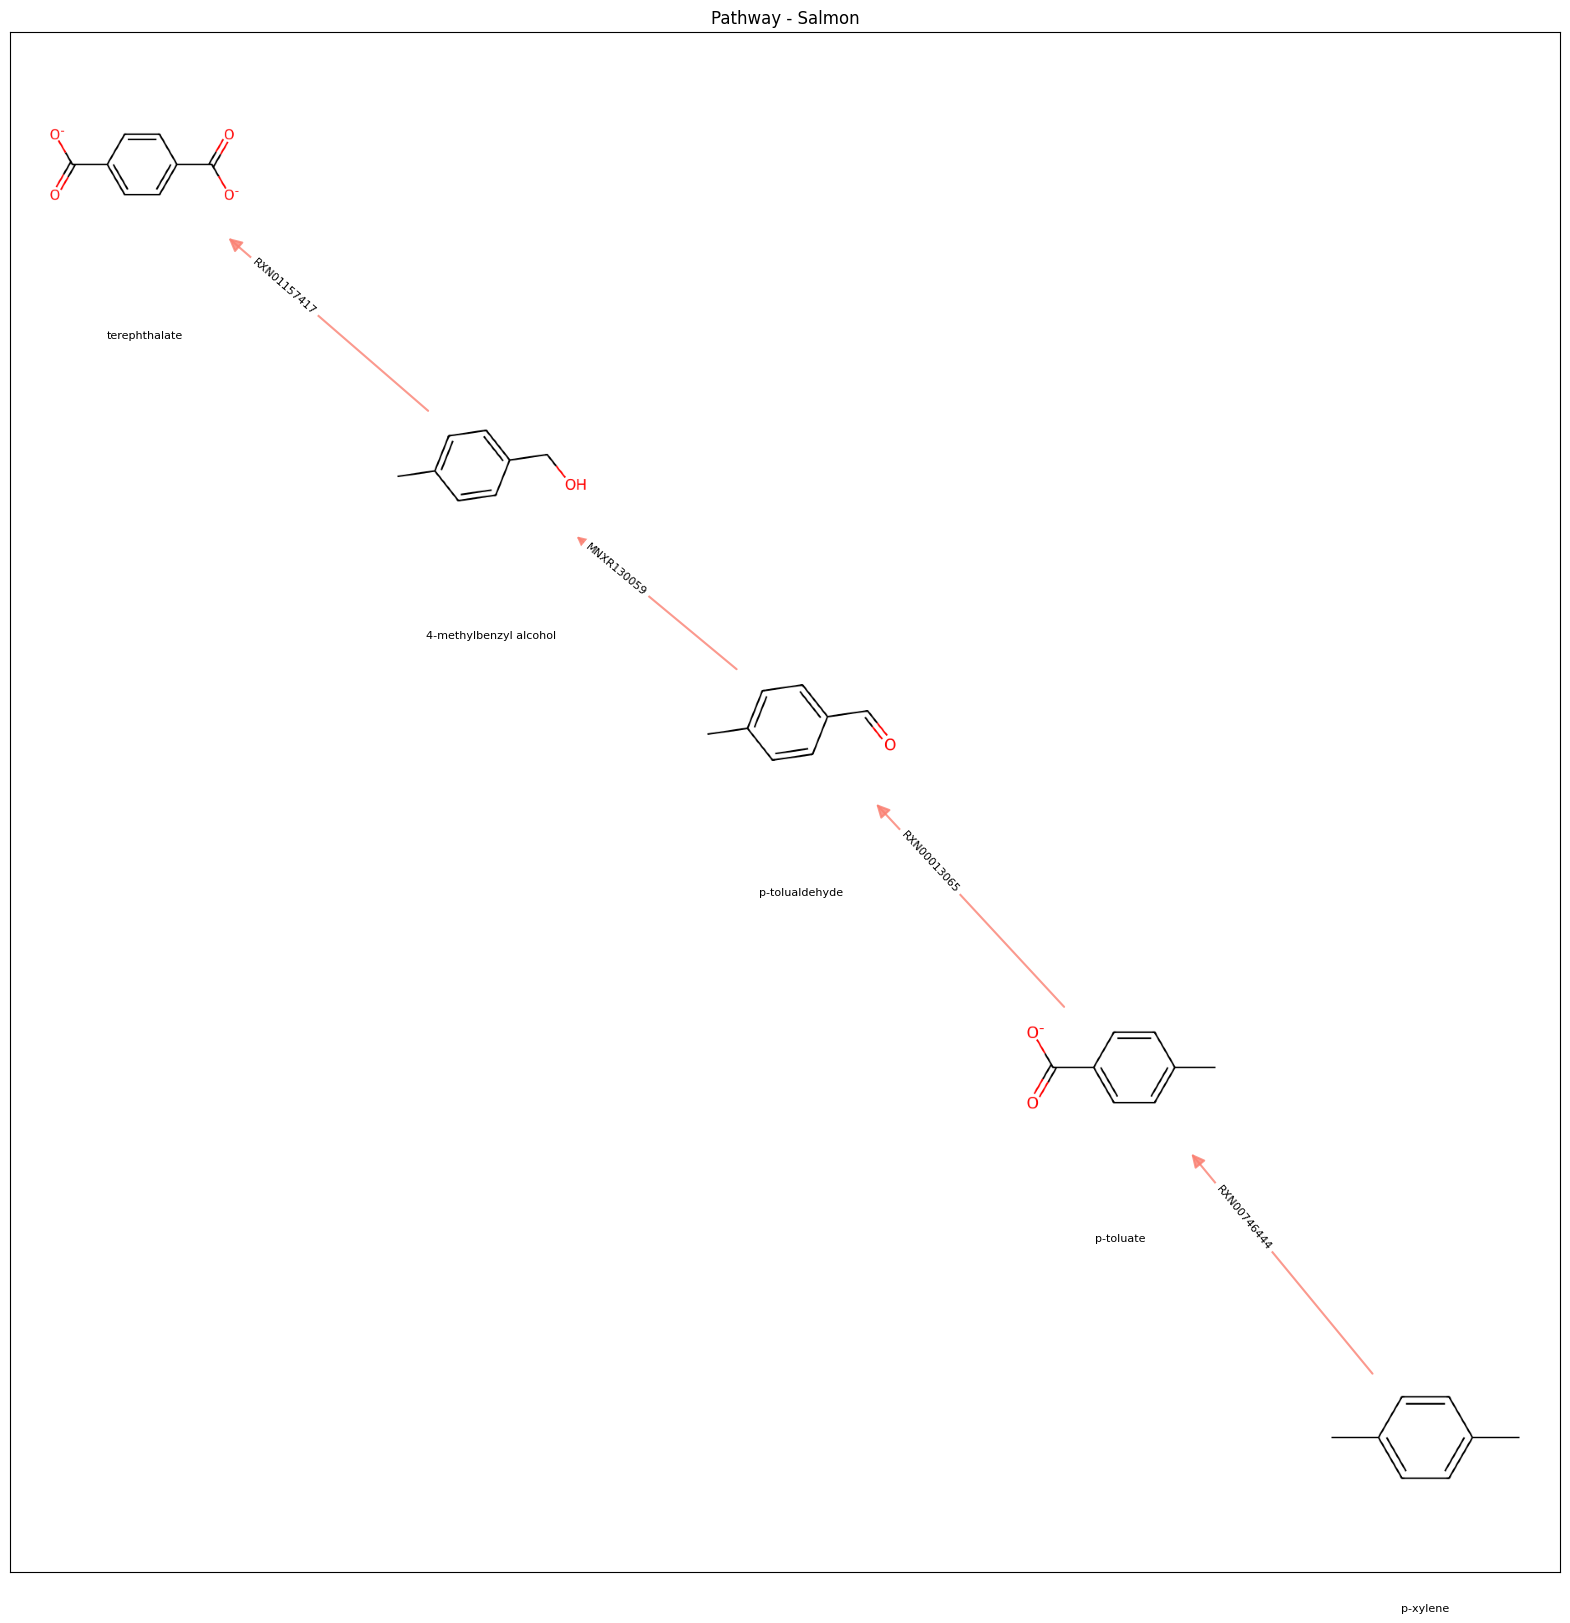

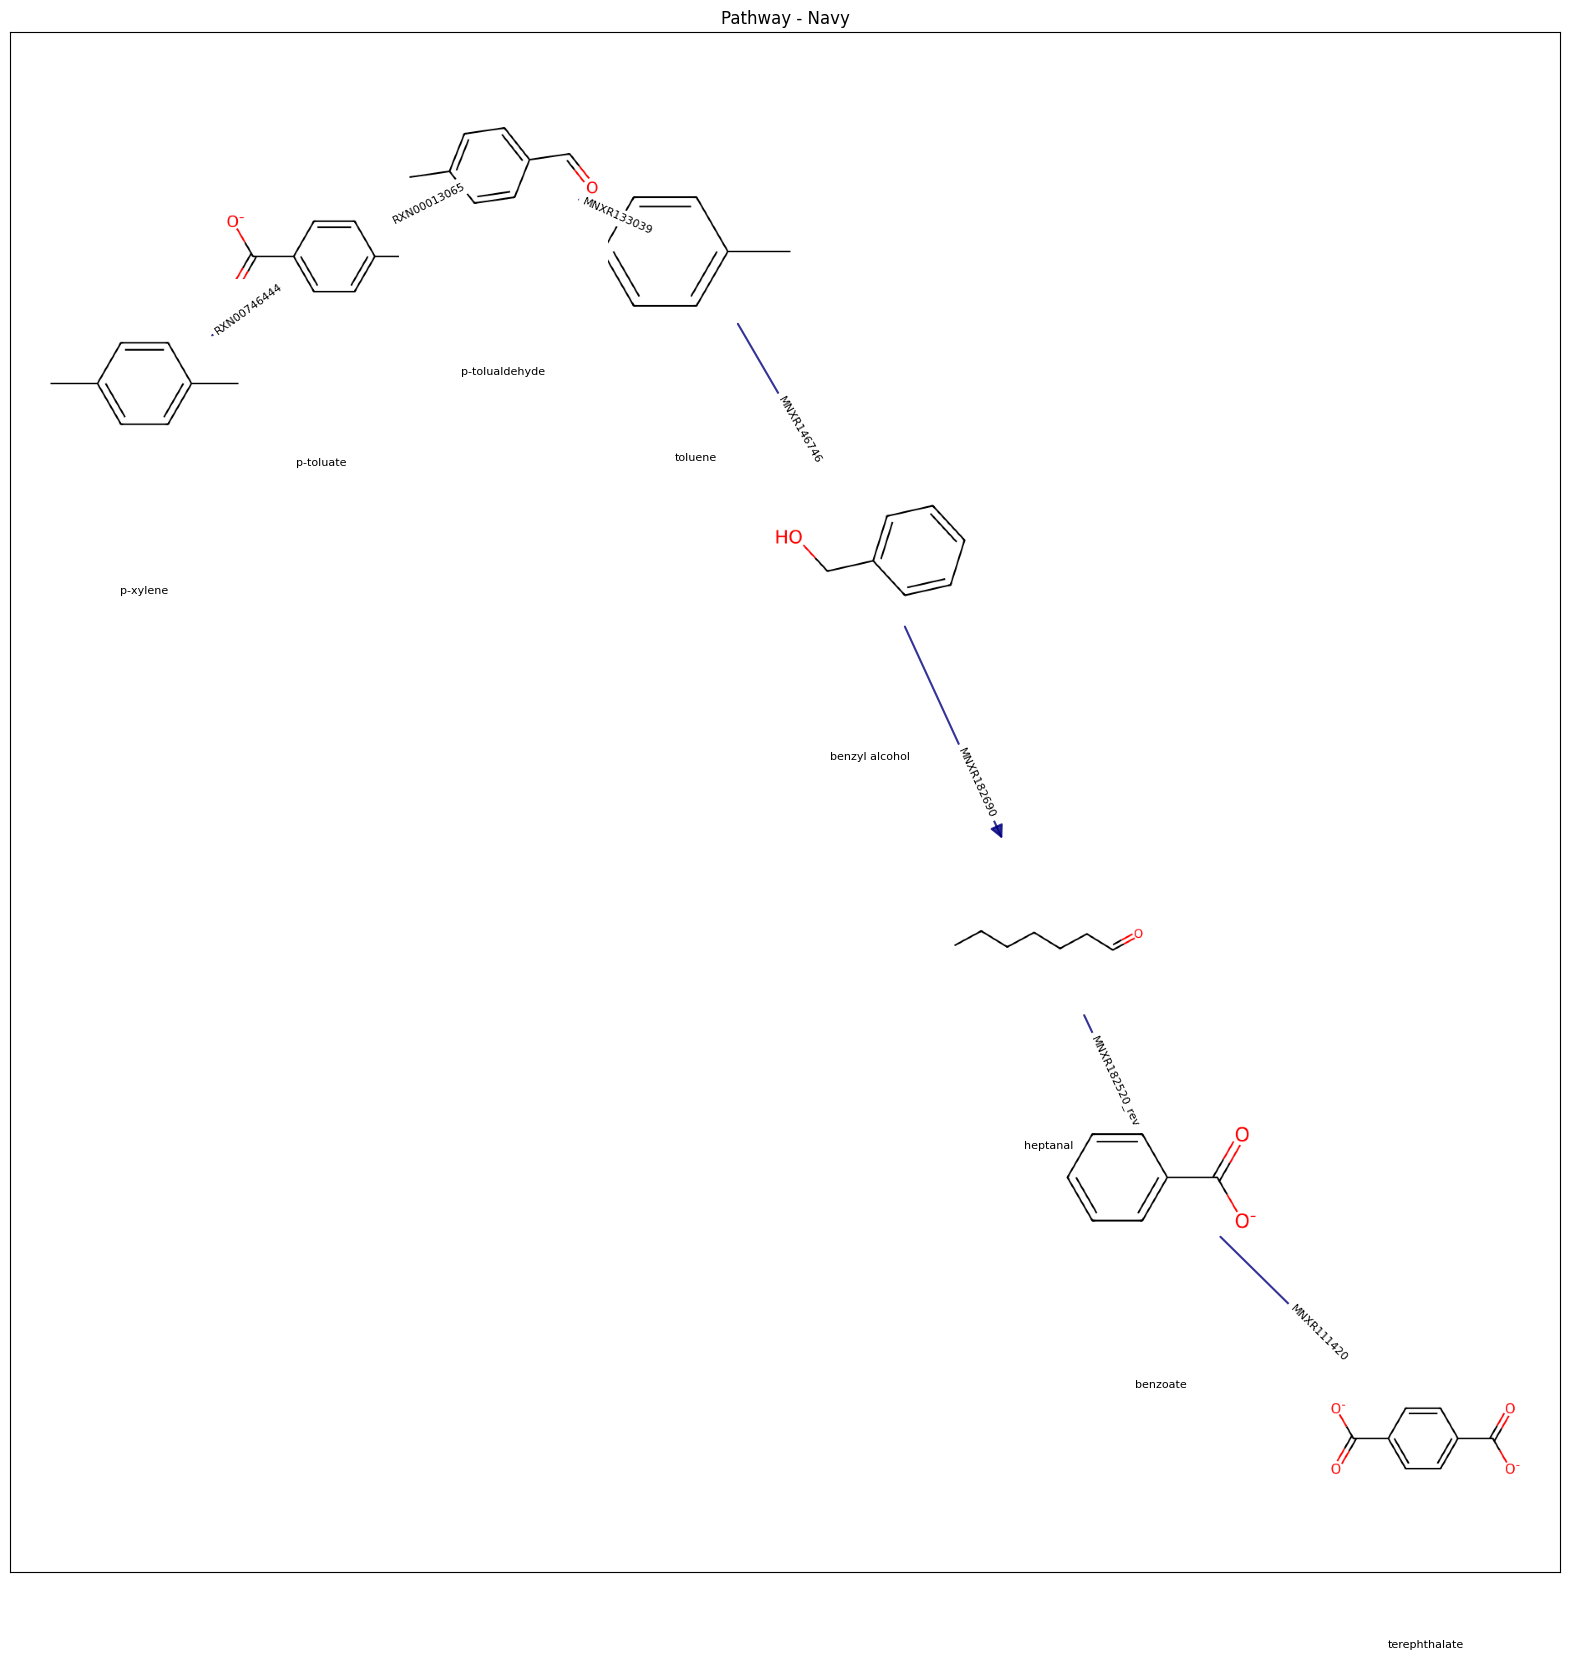

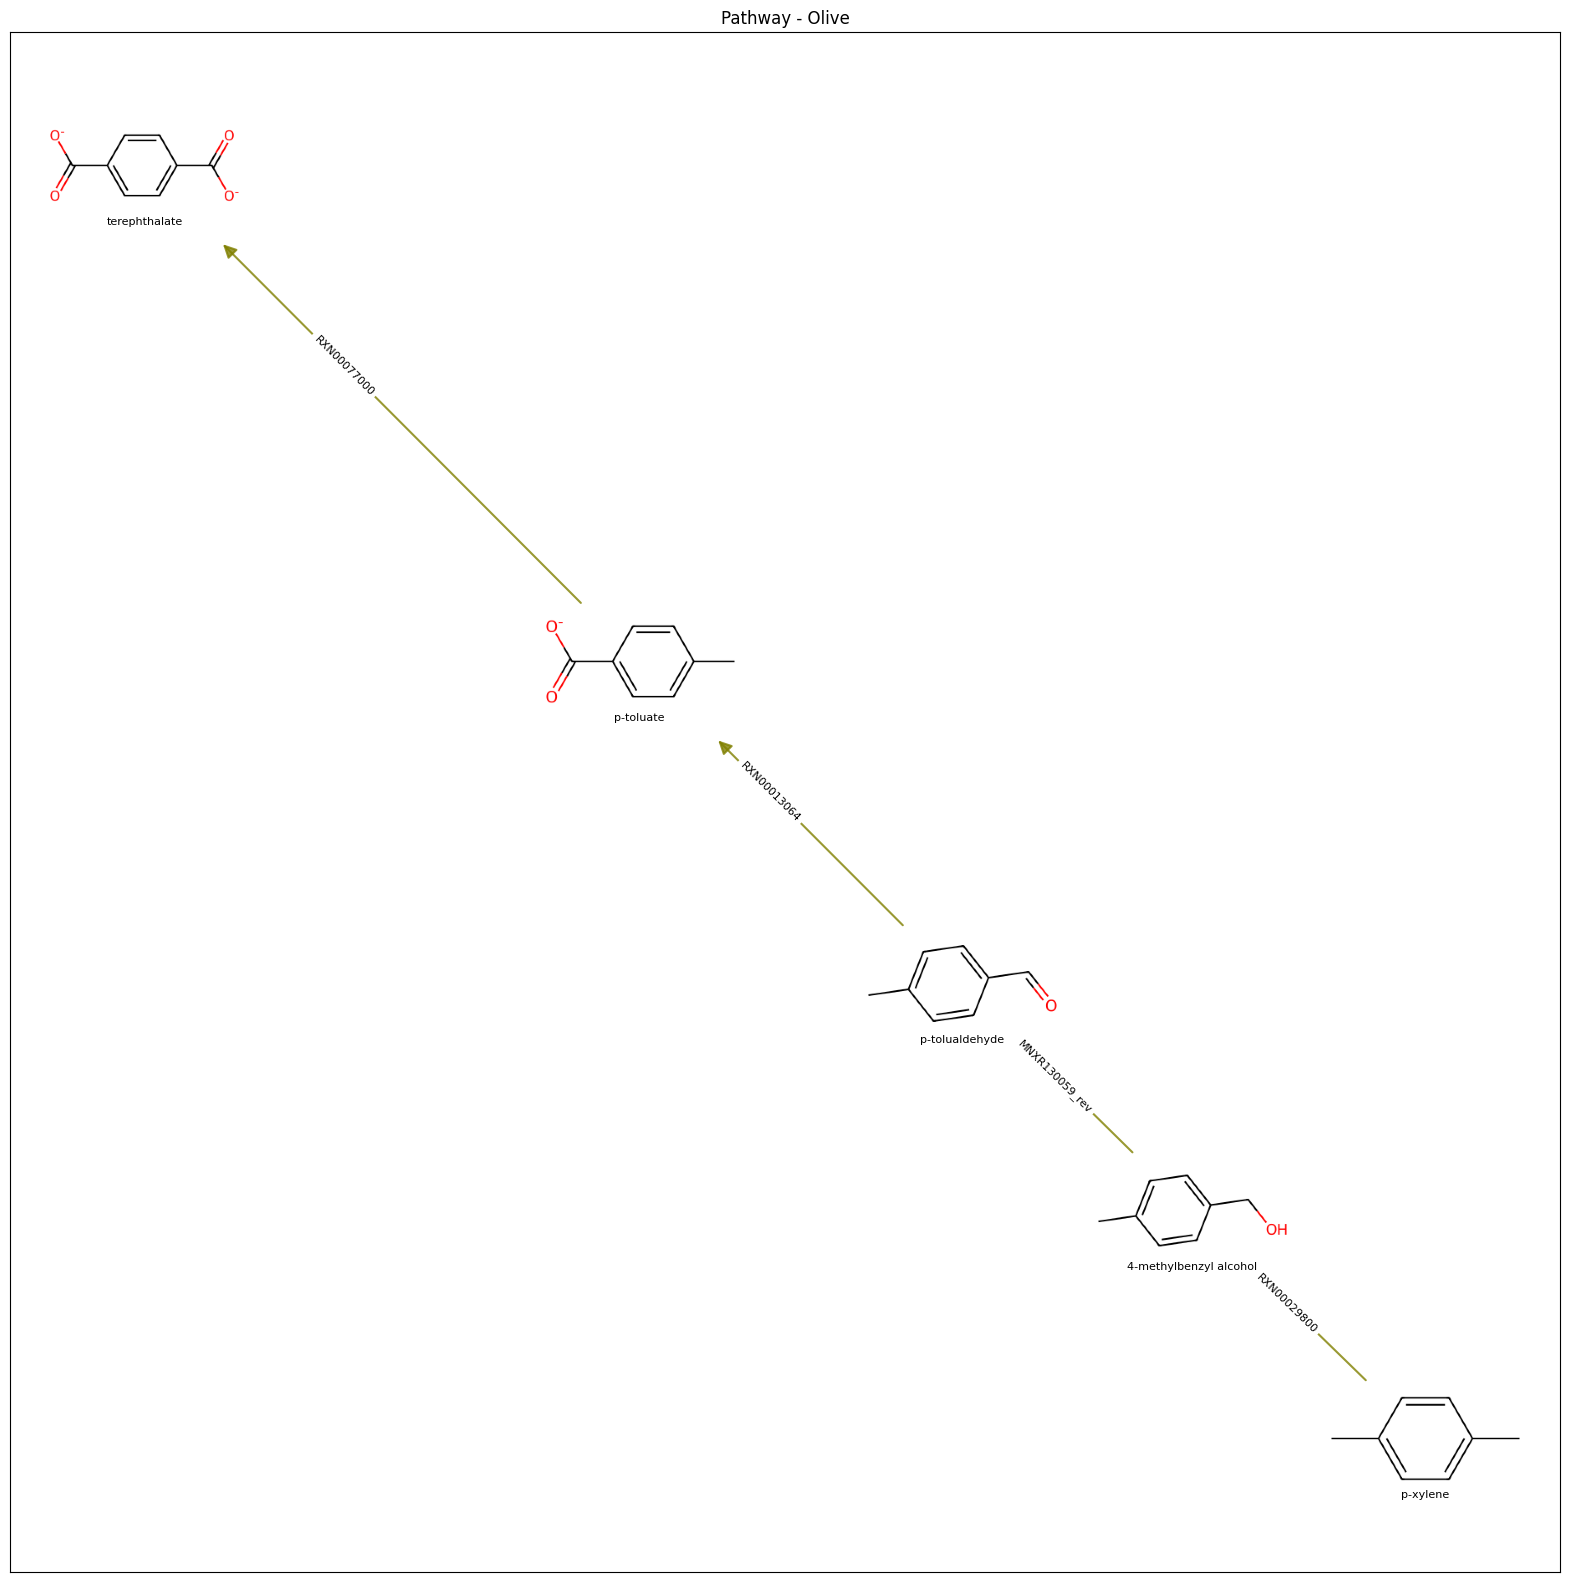

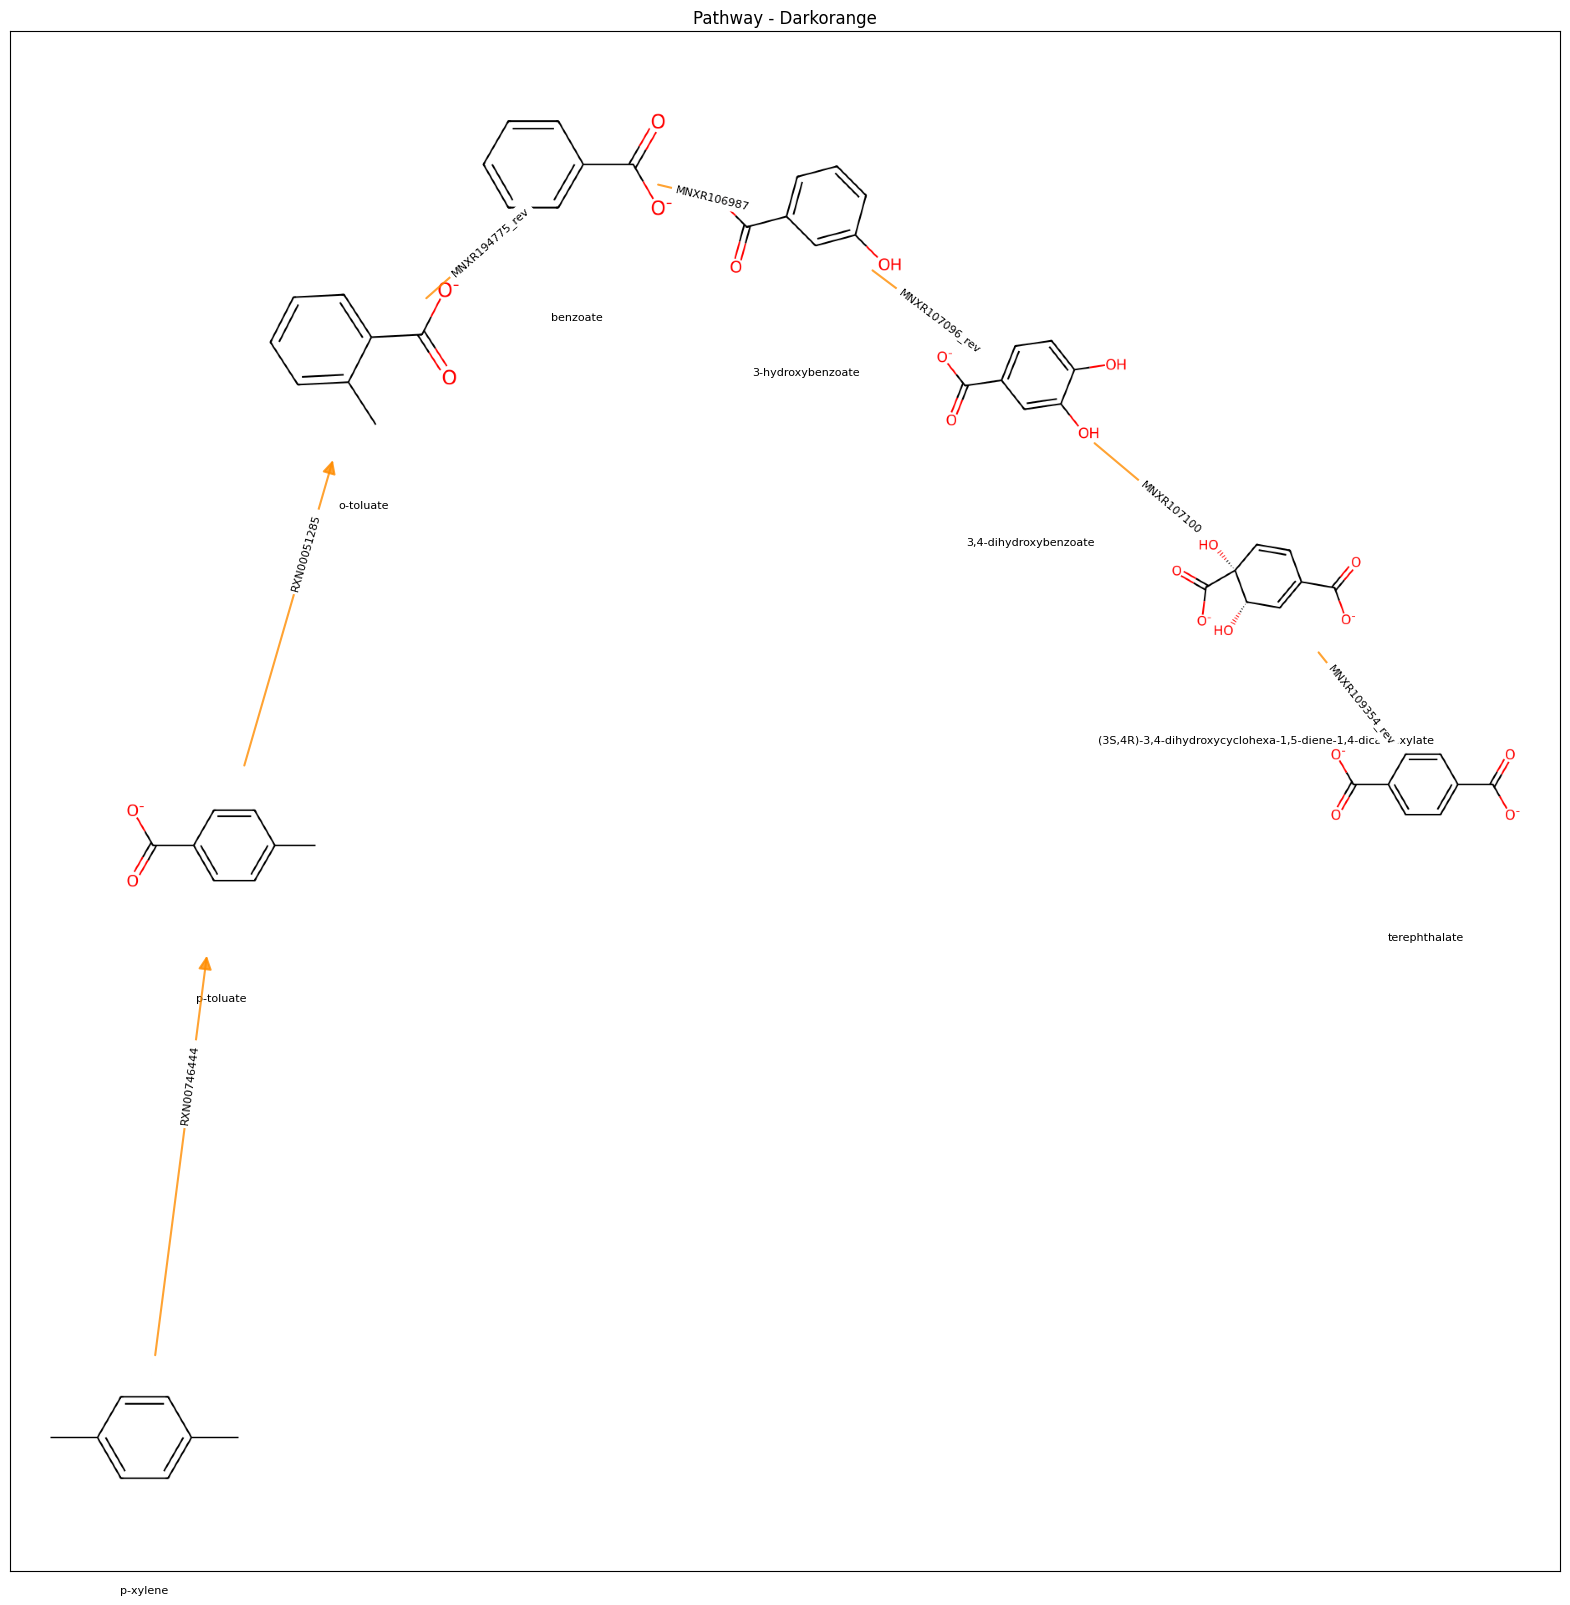

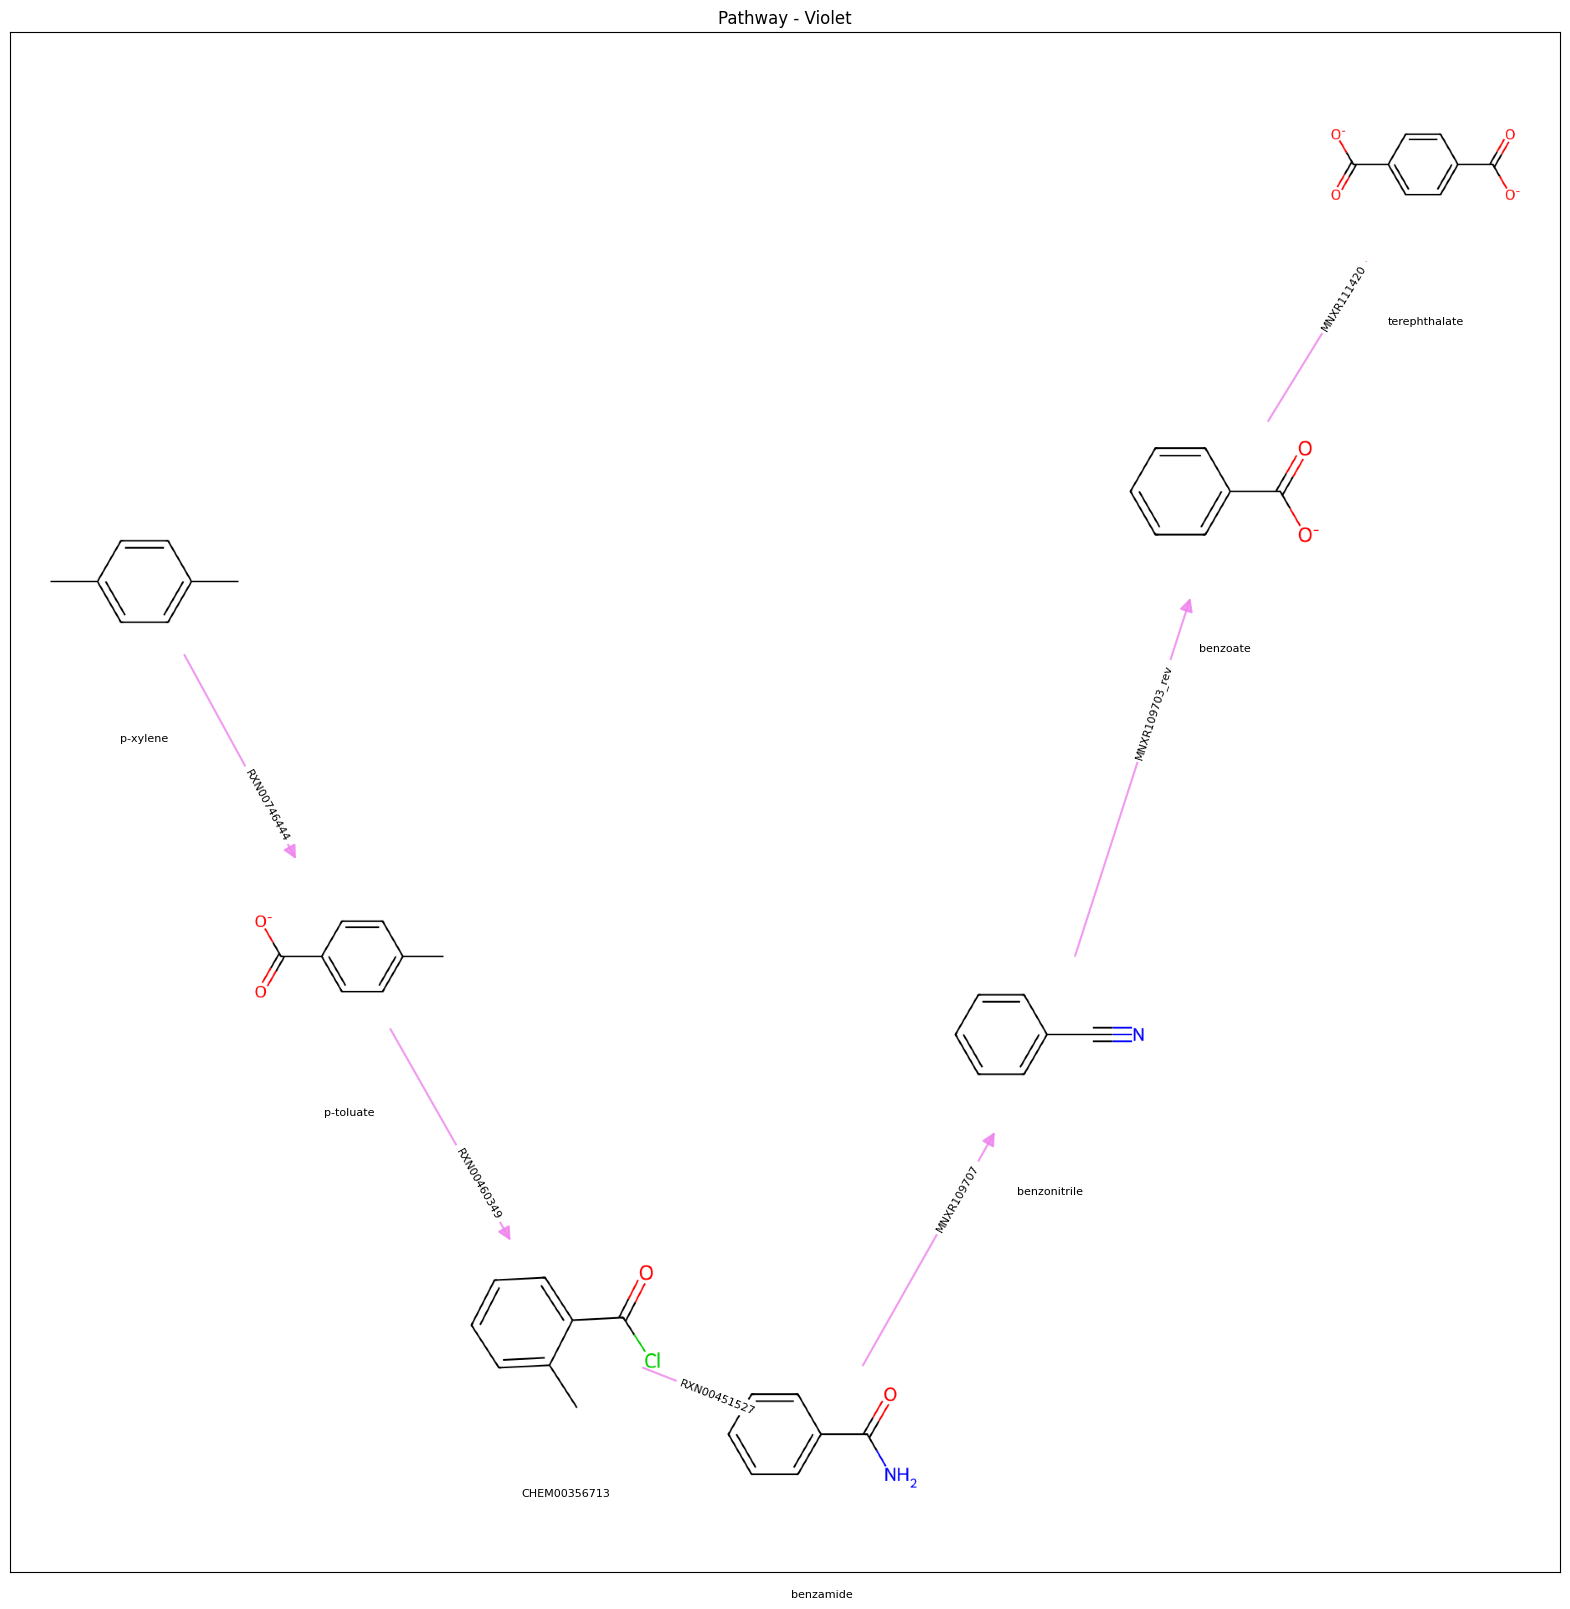

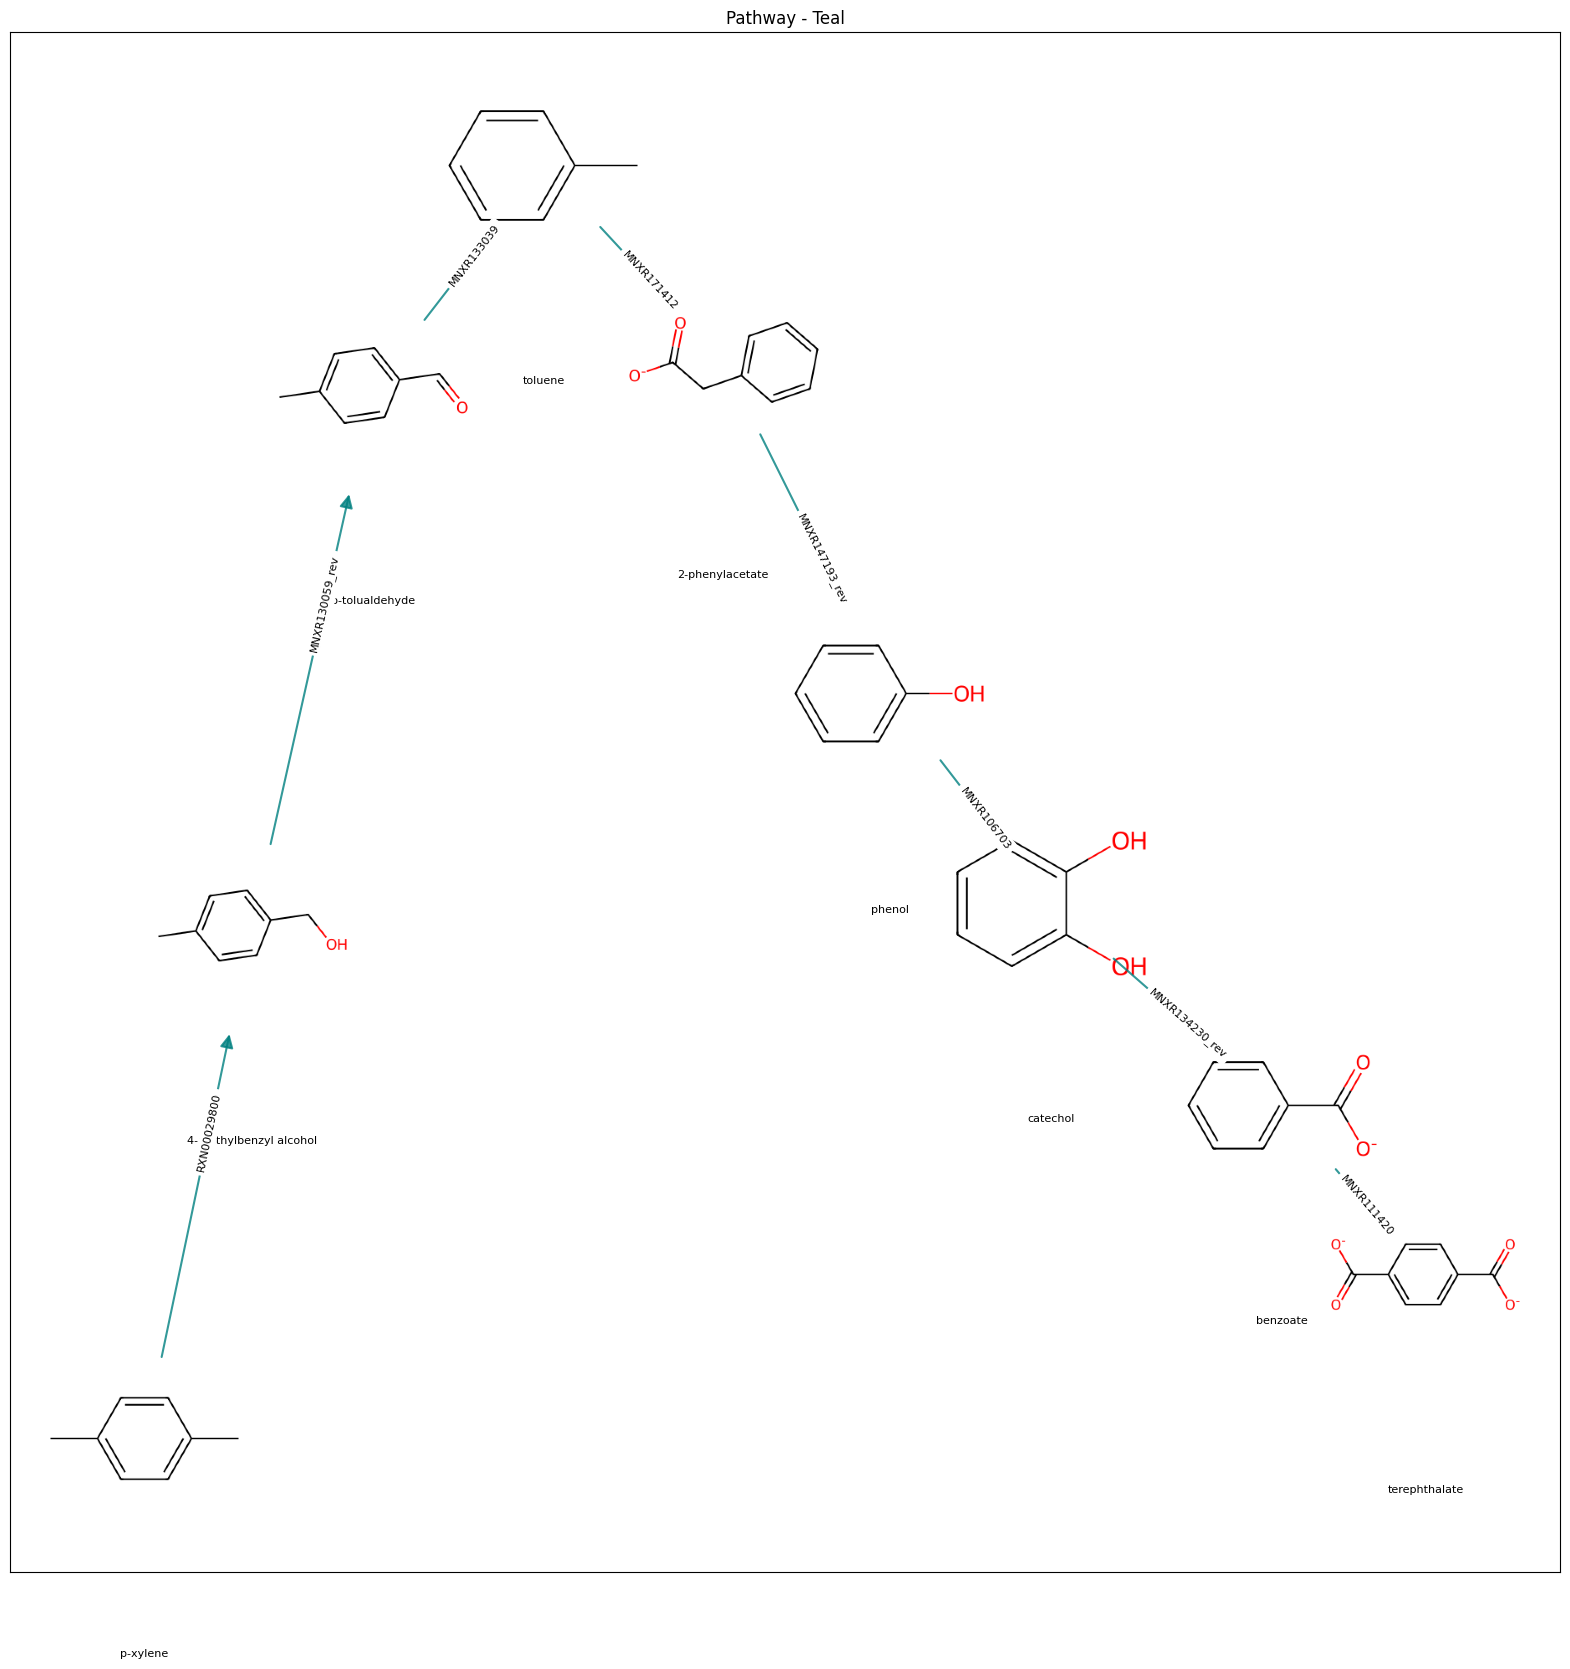

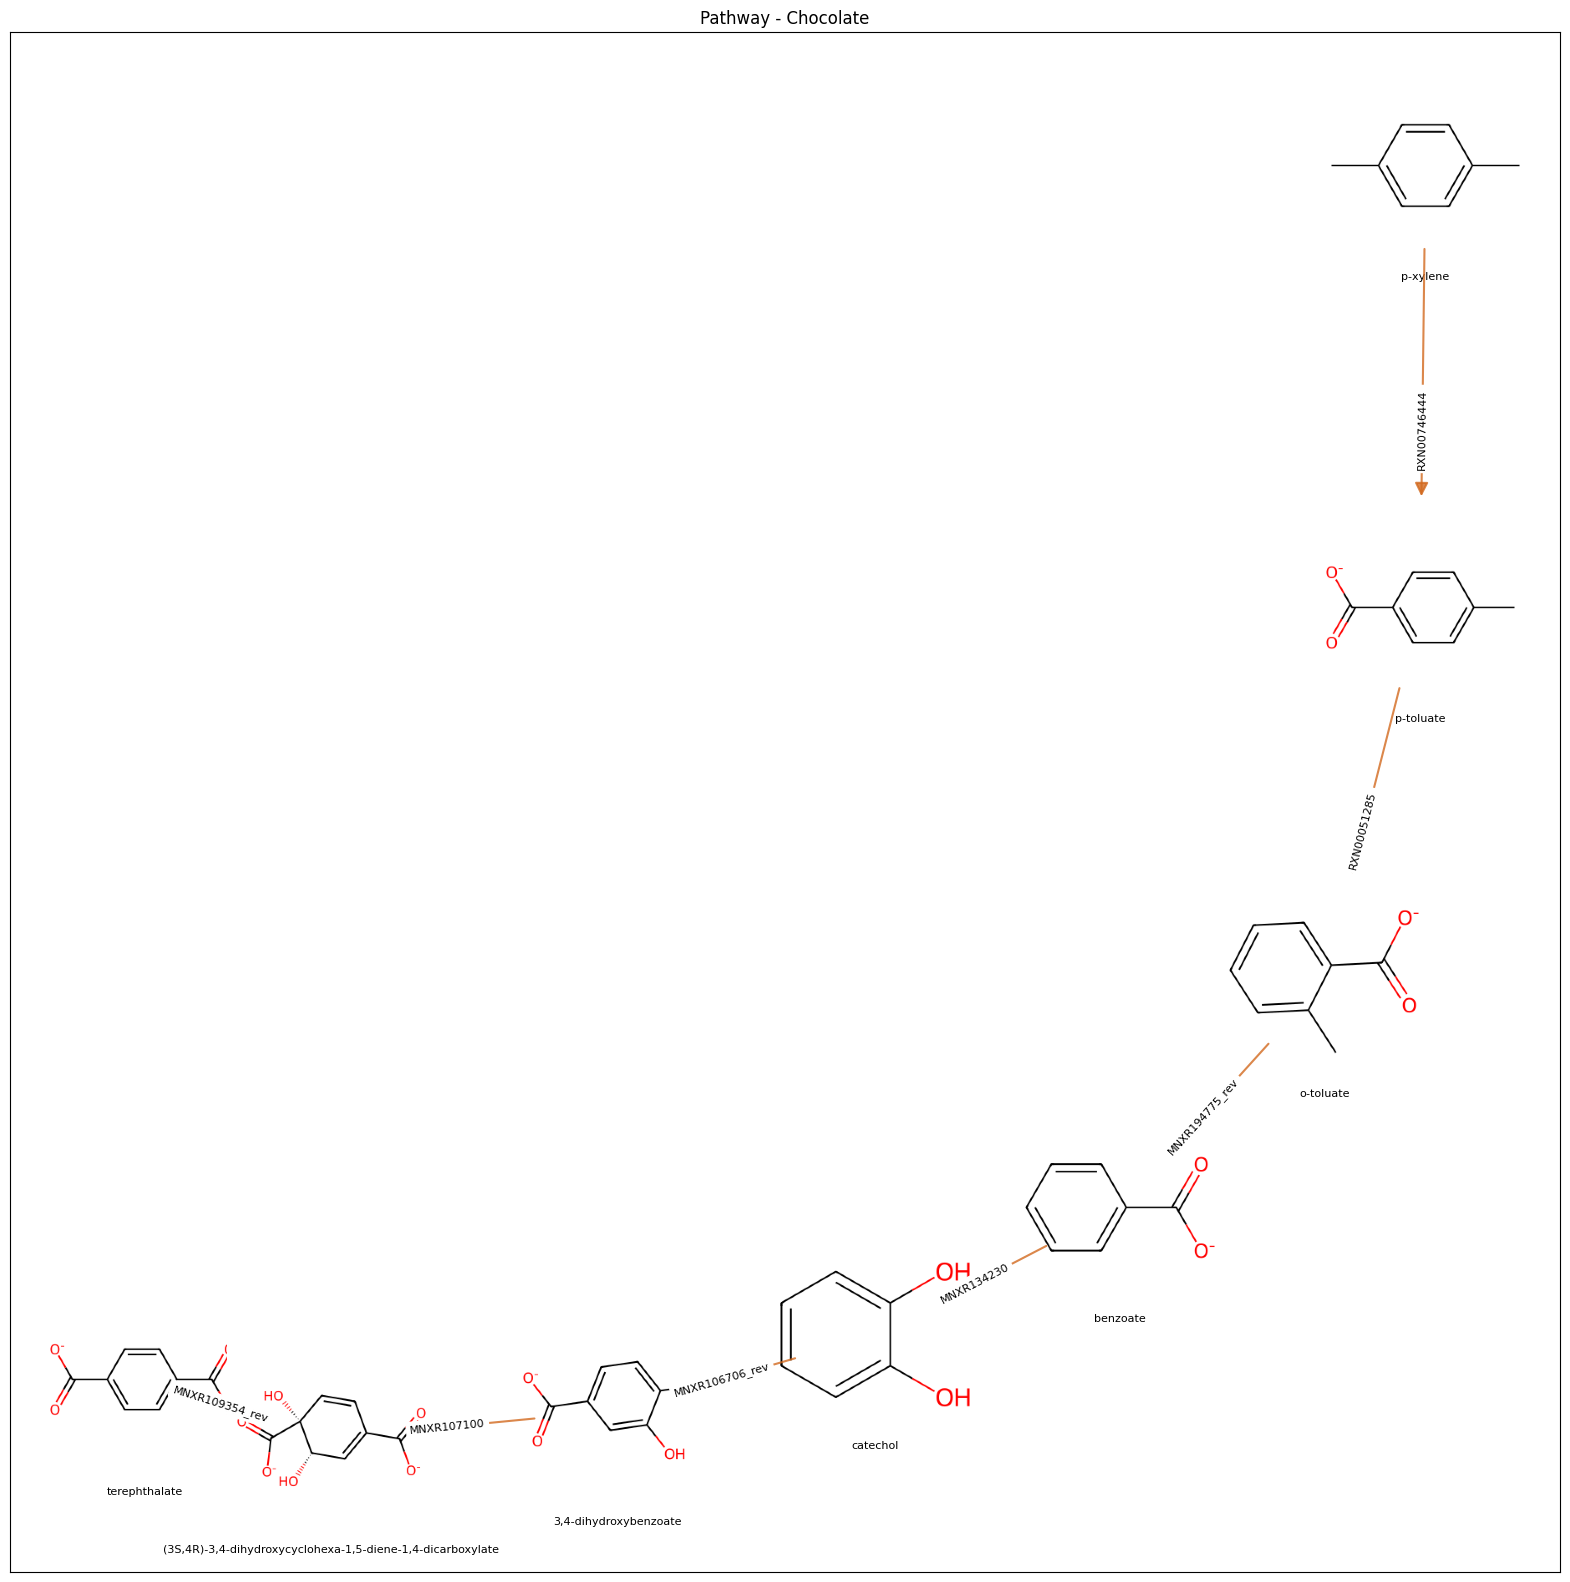

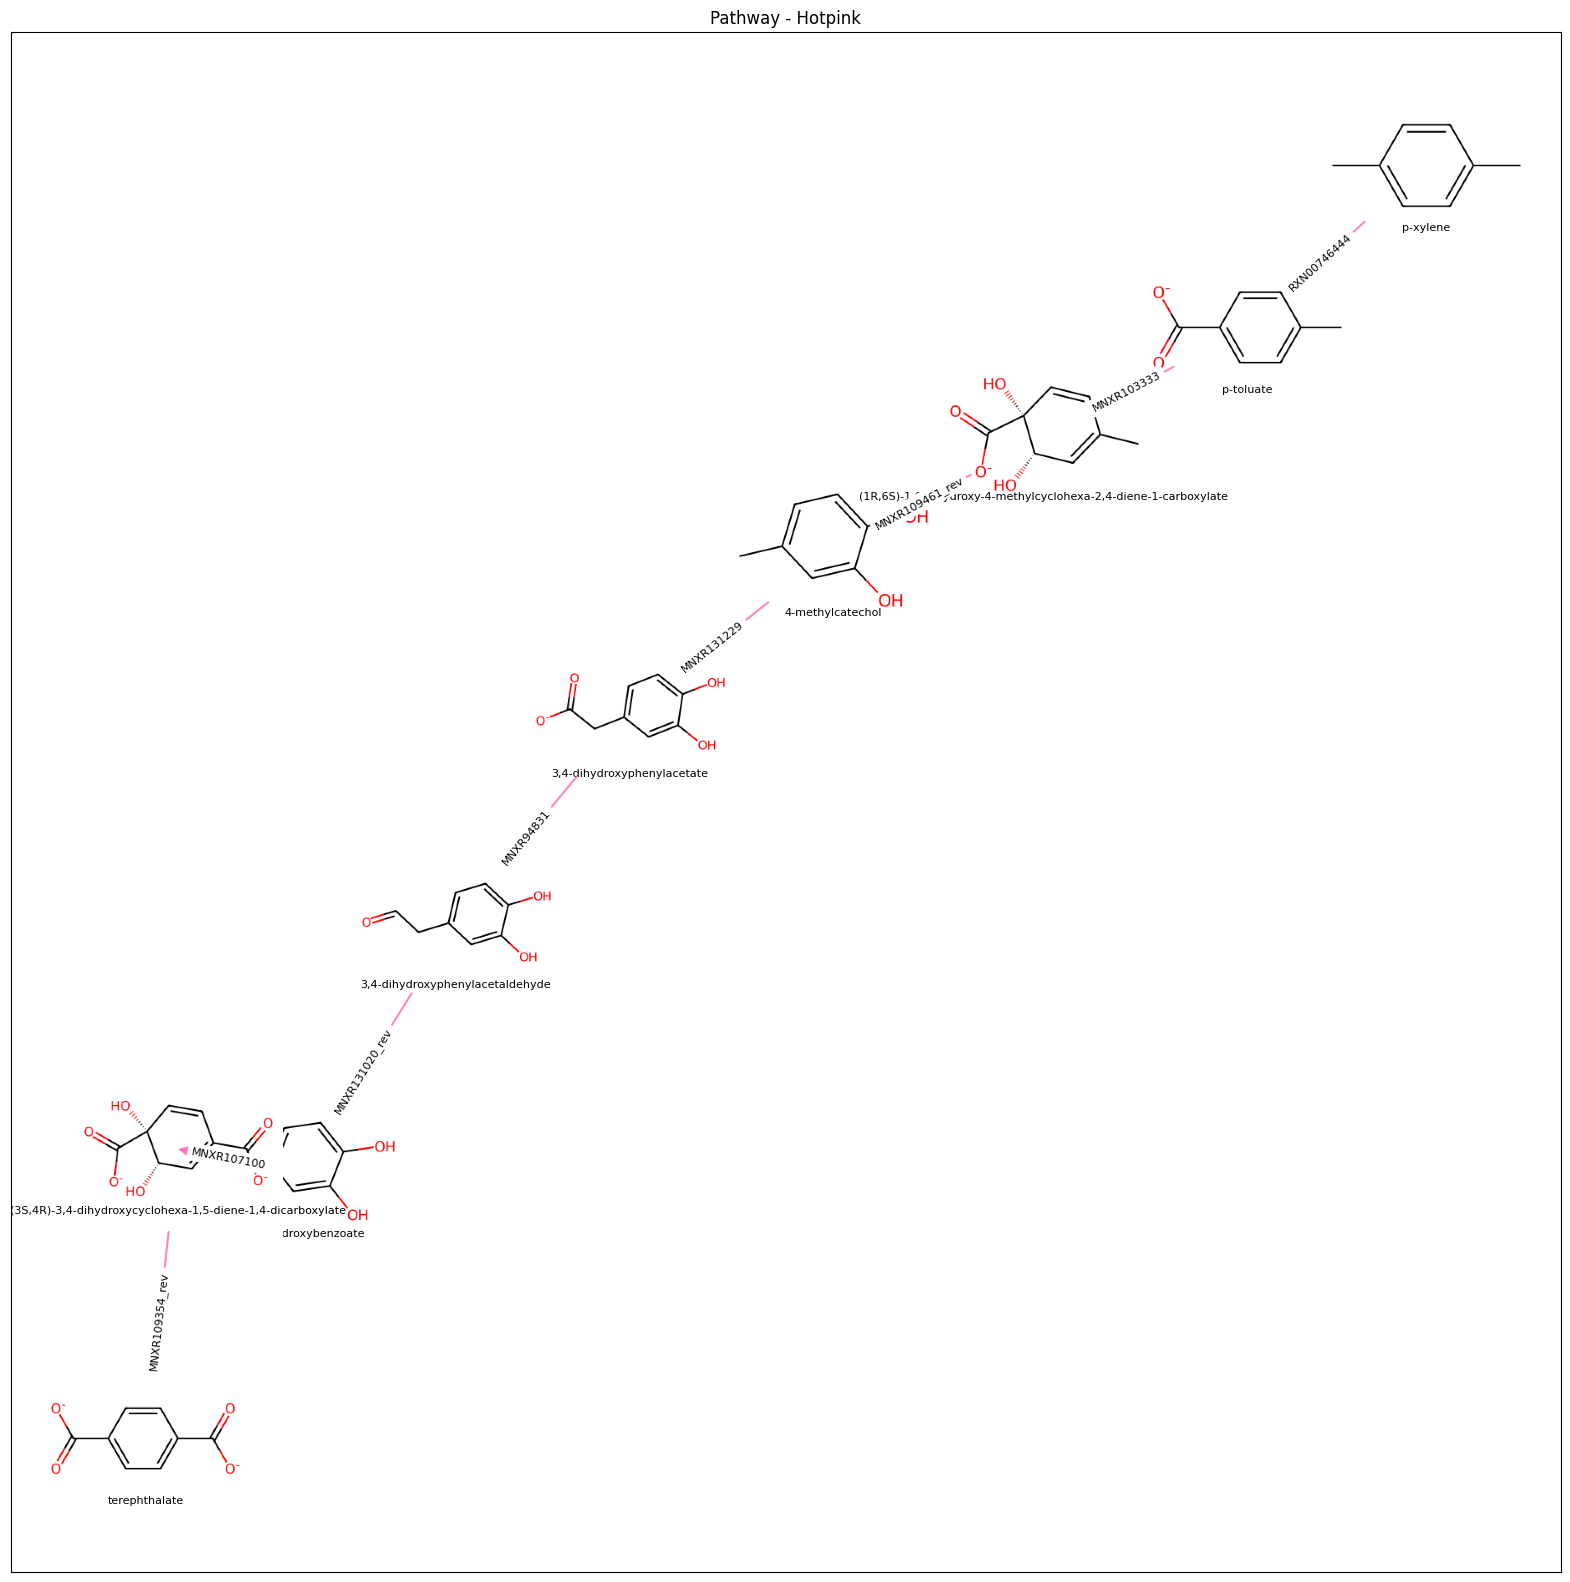

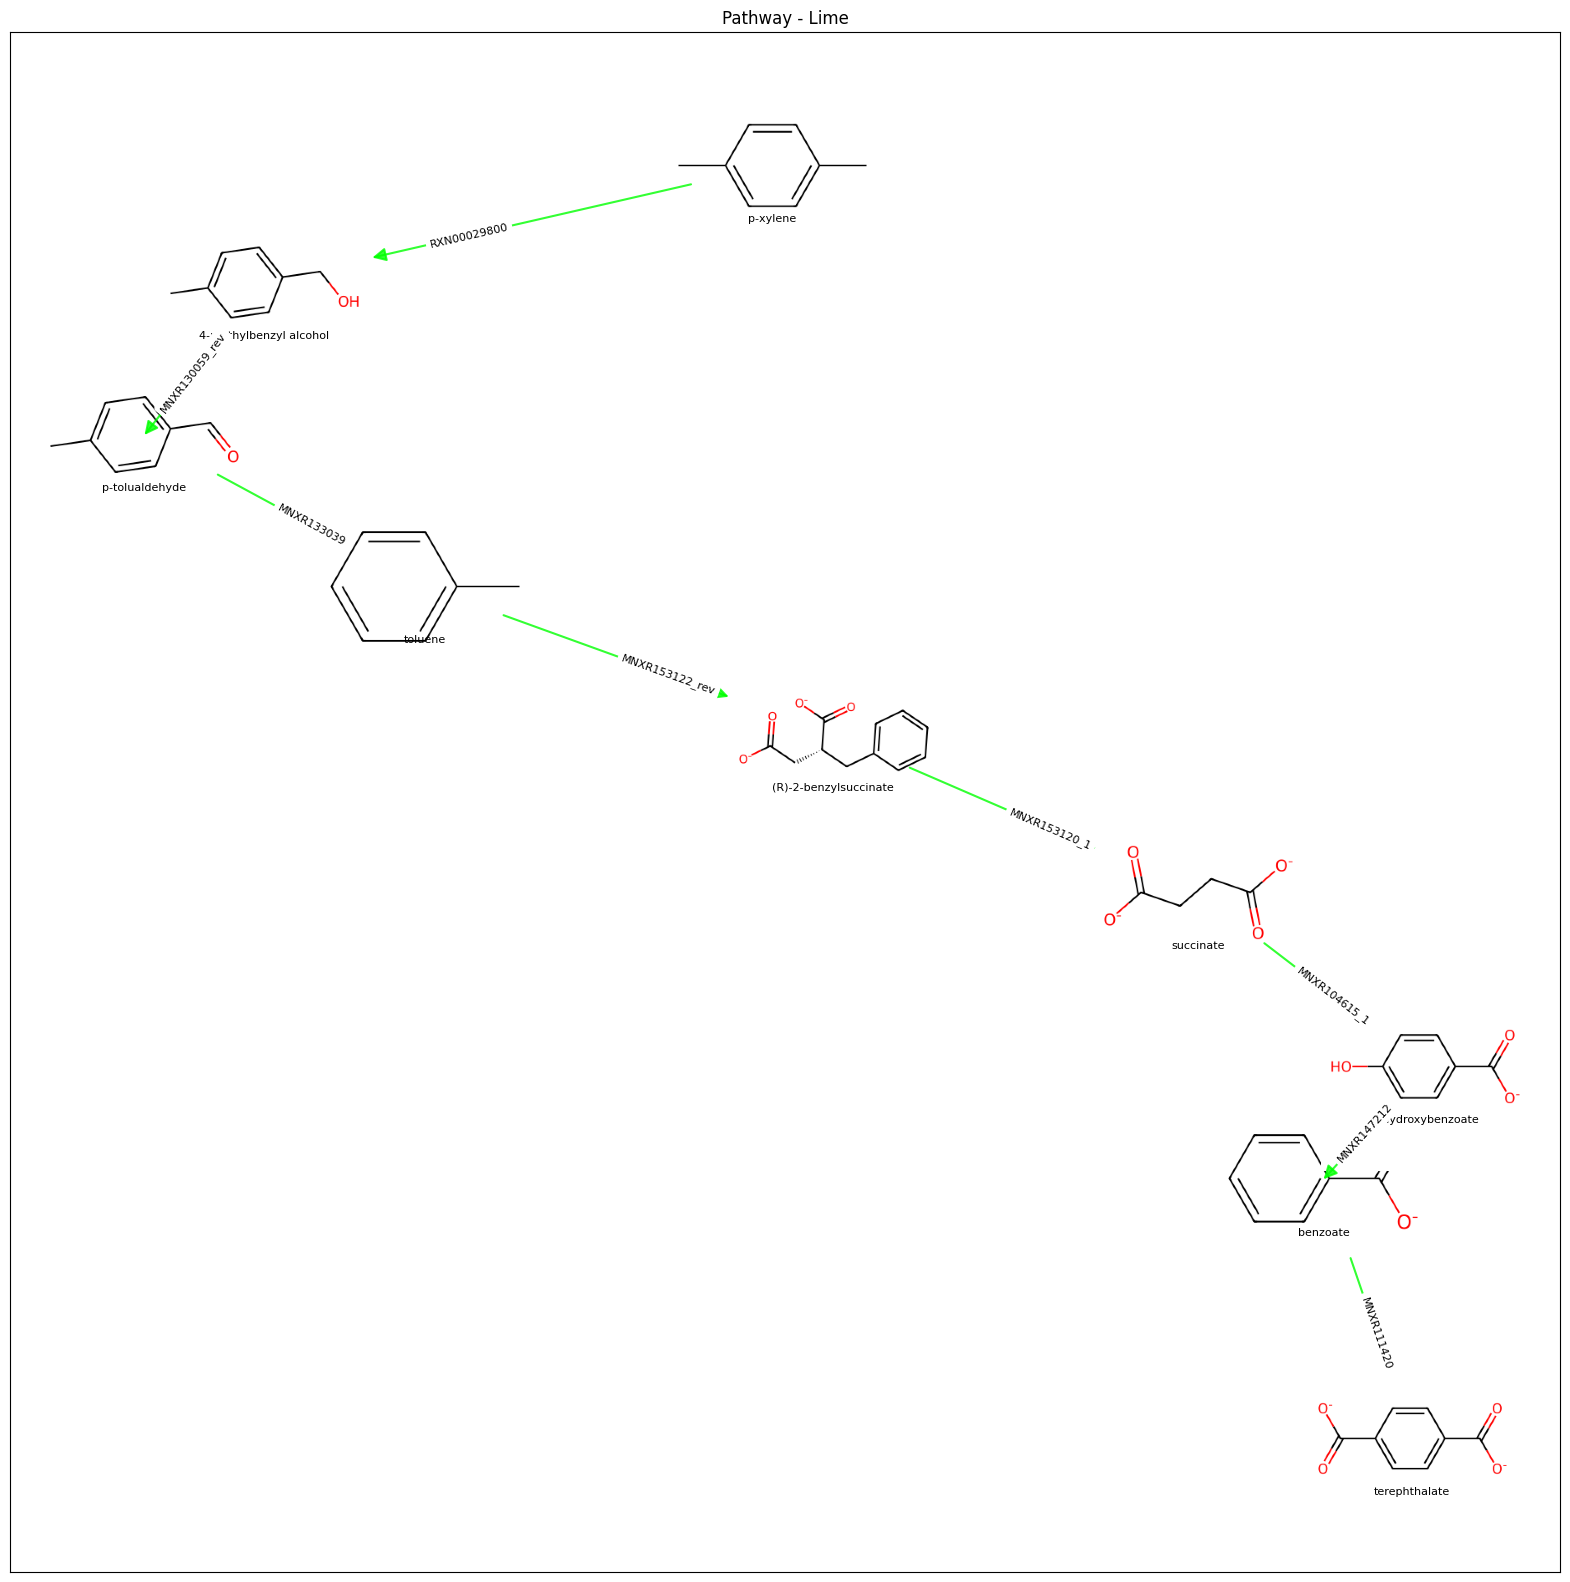

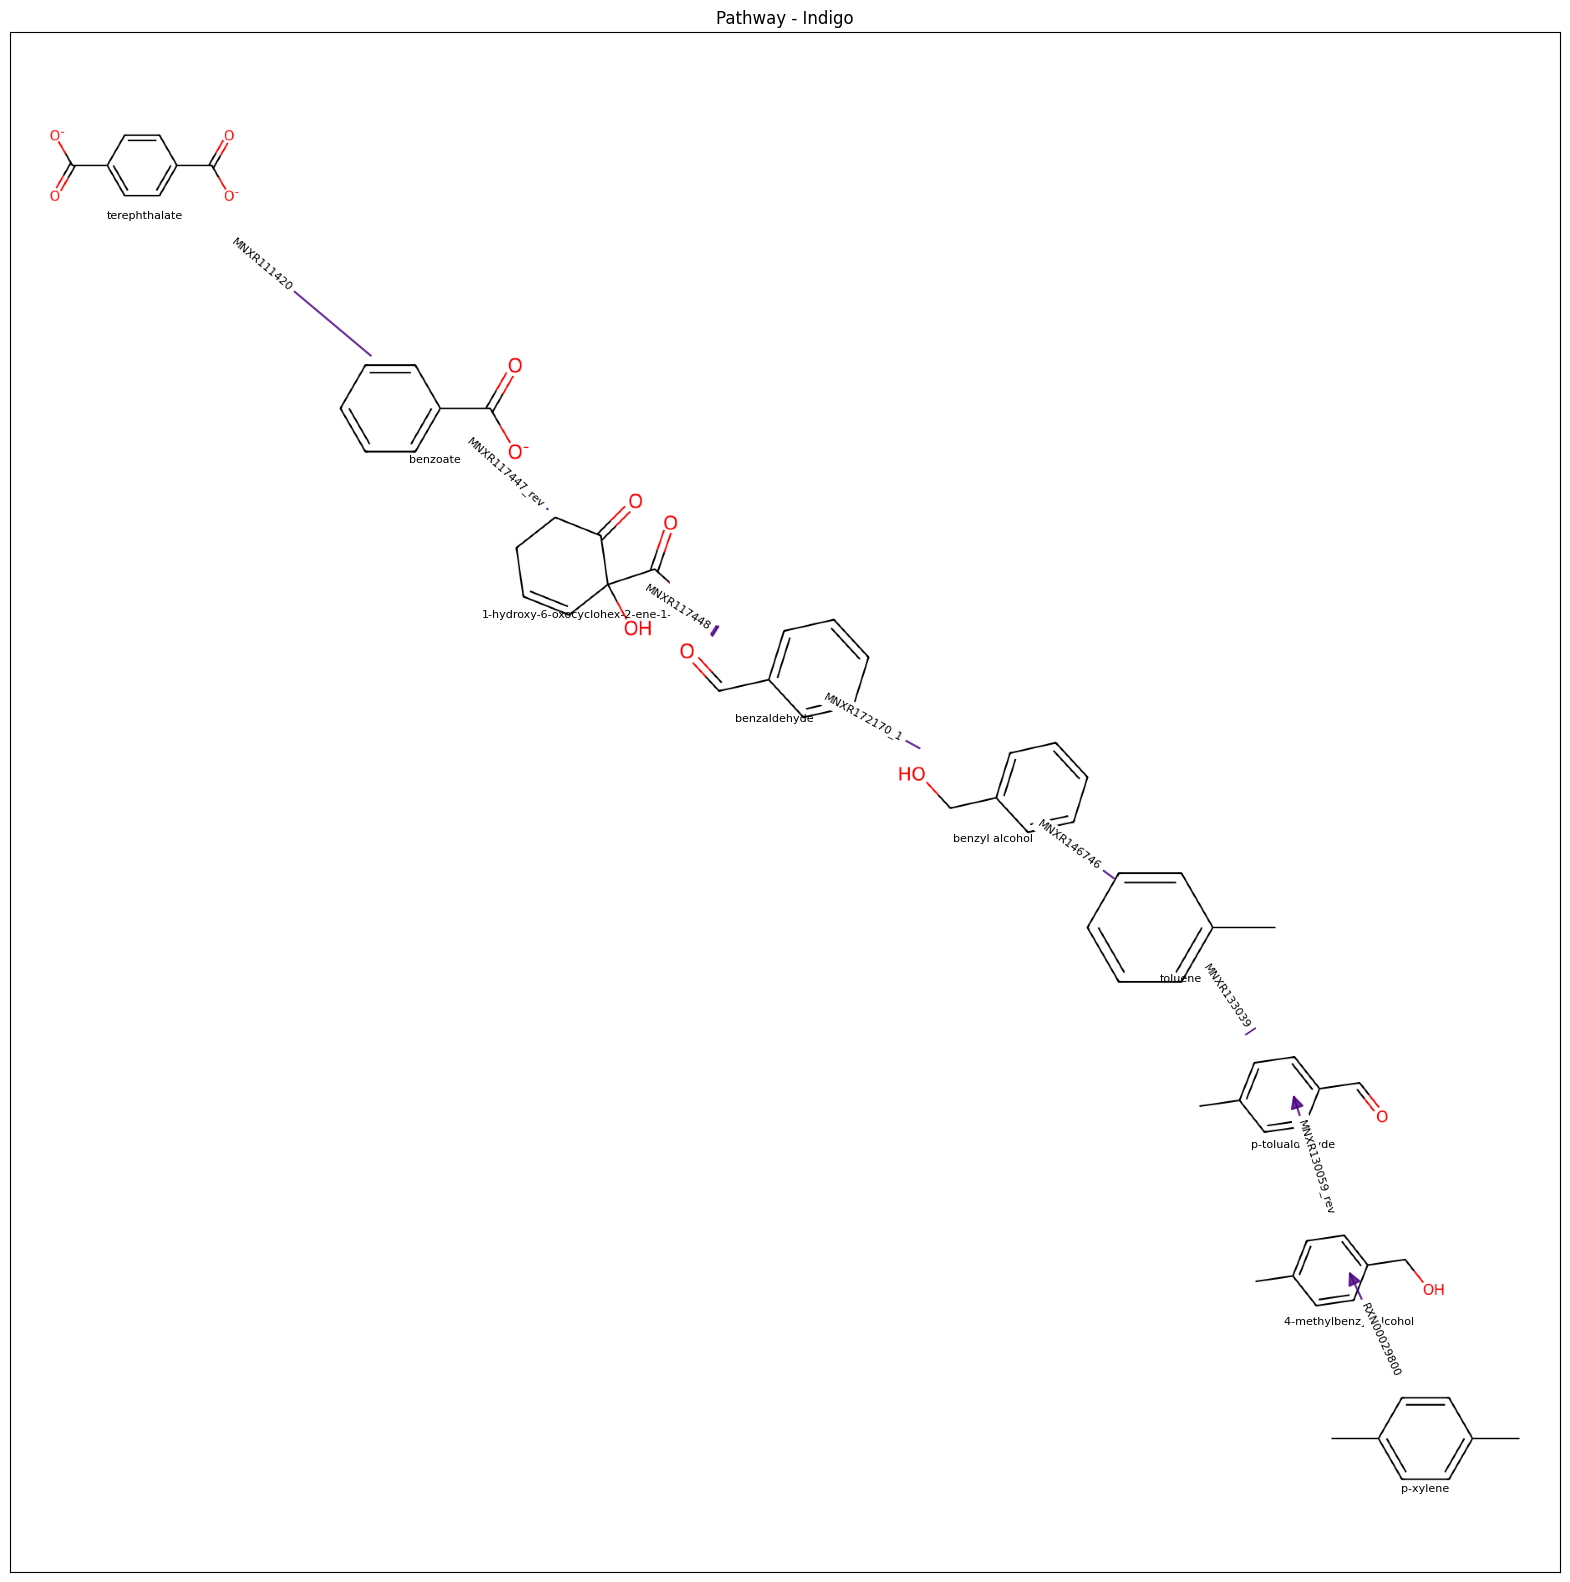

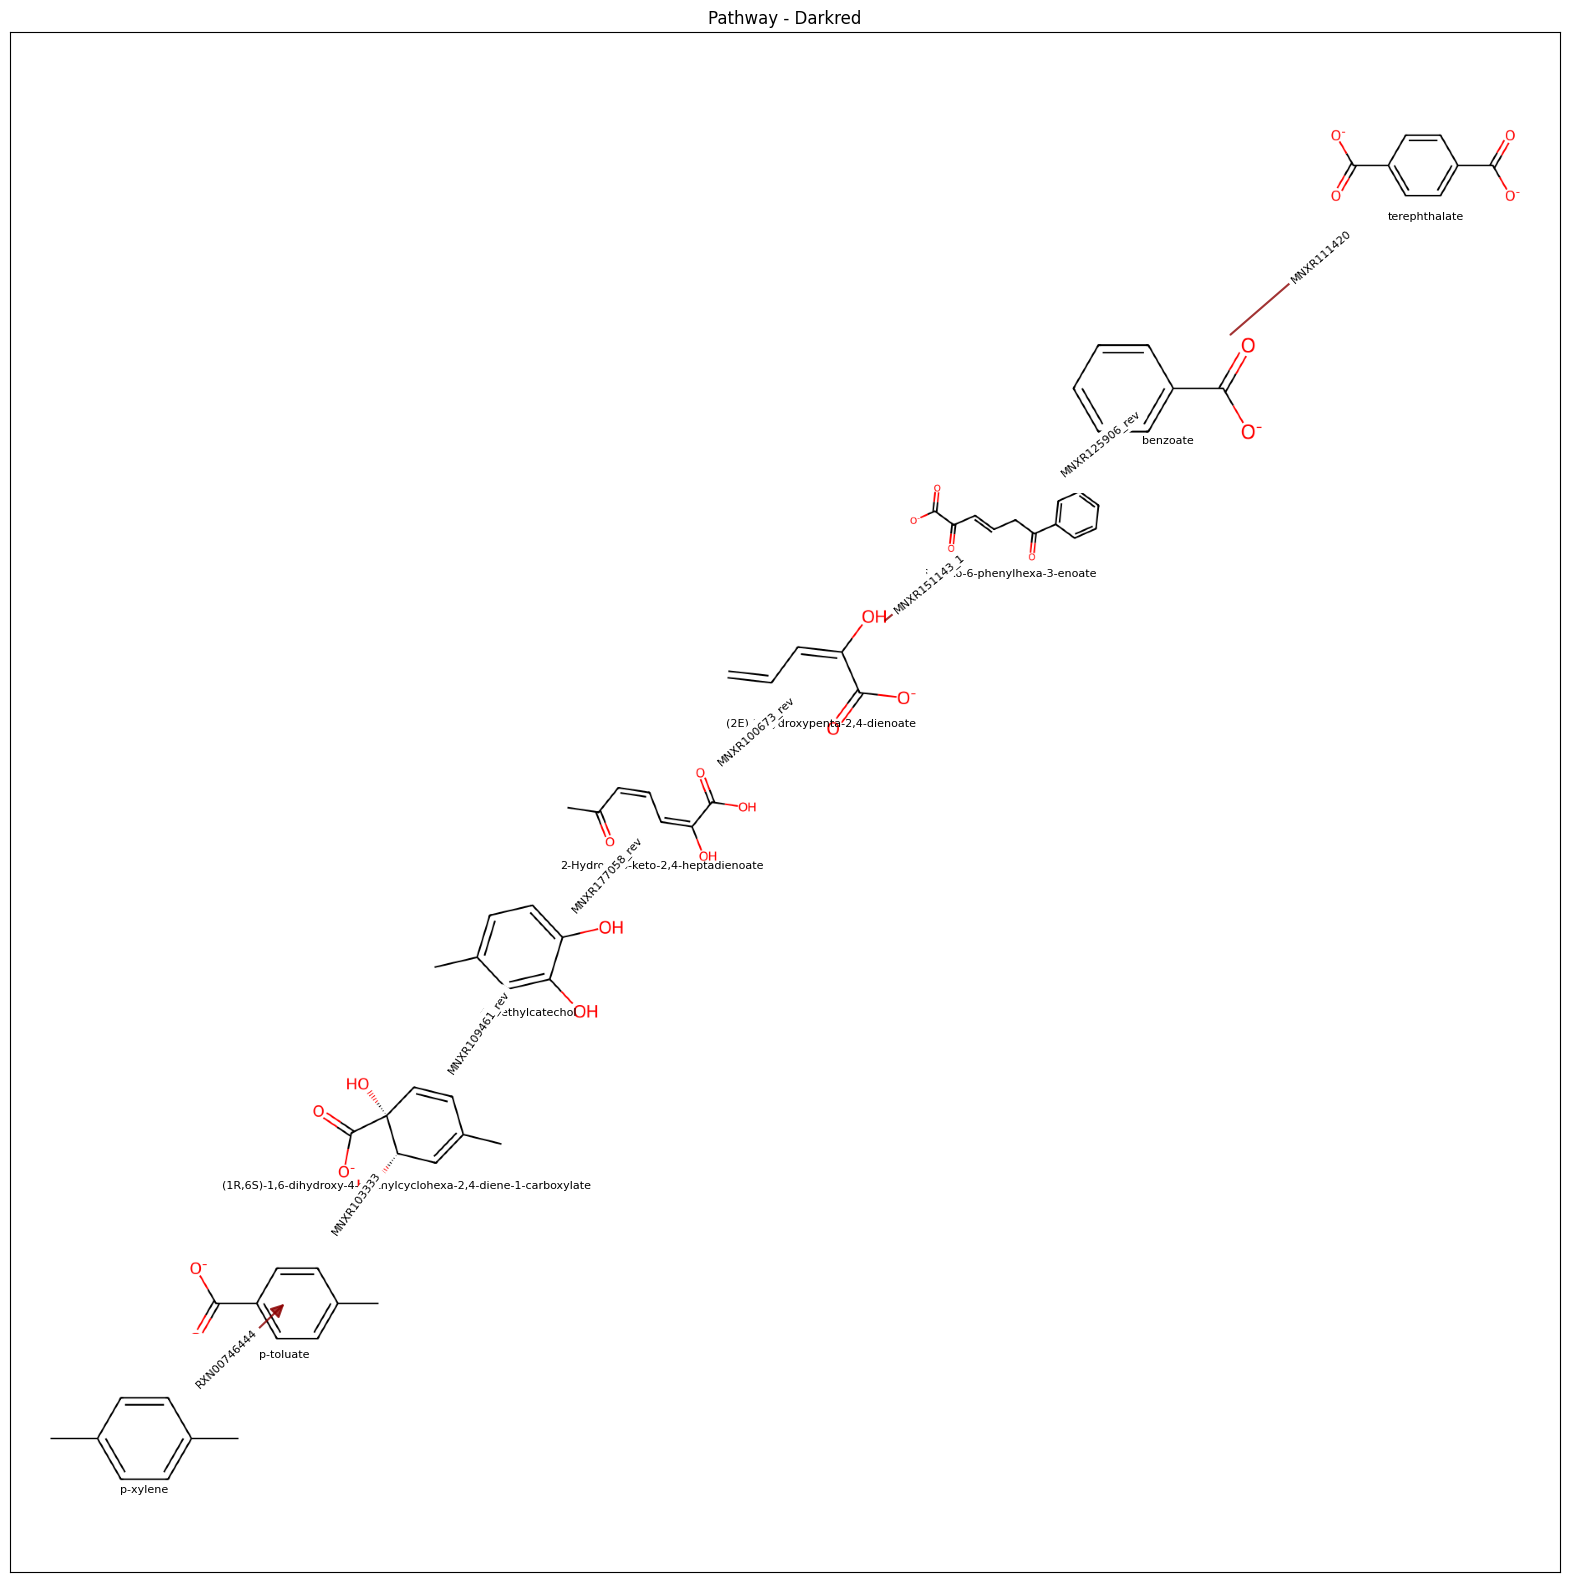

In [127]:
draw_individual_pathways_separate_2(molecules, pathways_w_colors_w_id, bio_chem_ids_dict, image_file_name,filename_prefix='synthesis_pathway')